In [1]:
#Don't forget to save your work to your local computer and push to GitHub.
#File -> Download as -> Notebook
#Move file from download folder to local repo clone
#git add filename.ipynb
#git commit -m "put a specific and informative message here of what you worked on"
#git push

# Import and Prepare Dataset - Custom Concept Set for Birth and Preterm Birth 

In this section:  
Import data; rename to long_data (in long format)   
Remove irrelevant values for "condition" (e.g. "second trimester pregnancy" is too vague)    
Convert datetime cells to date only

## Import dataset

In [2]:
import pandas
import pandas as pd
import os
import numpy as np
import time

# This query represents dataset "Concept Set Exploration" for domain "condition" and was generated for All of Us Controlled Tier Dataset v7
dataset_87730747_condition_sql = """
    SELECT
        c_occurrence.person_id,
        c_standard_concept.concept_name as standard_concept_name,
        c_occurrence.condition_start_datetime 
    FROM
        ( SELECT
            * 
        FROM
            `""" + os.environ["WORKSPACE_CDR"] + """.condition_occurrence` c_occurrence 
        WHERE
            (
                condition_concept_id IN  (
                    SELECT
                        DISTINCT c.concept_id 
                    FROM
                        `""" + os.environ["WORKSPACE_CDR"] + """.cb_criteria` c 
                    JOIN
                        (
                            select
                                cast(cr.id as string) as id 
                            FROM
                                `""" + os.environ["WORKSPACE_CDR"] + """.cb_criteria` cr 
                            WHERE
                                concept_id IN (
                                    36712702, 4014295, 432441, 44784550, 45757175, 45757176
                                ) 
                                AND full_text LIKE '%_rank1]%'
                        ) a 
                            ON (
                                c.path LIKE CONCAT('%.',
                            a.id,
                            '.%') 
                            OR c.path LIKE CONCAT('%.',
                            a.id) 
                            OR c.path LIKE CONCAT(a.id,
                            '.%') 
                            OR c.path = a.id) 
                        WHERE
                            is_standard = 1 
                            AND is_selectable = 1
                        )
                )  
                AND (
                    c_occurrence.PERSON_ID IN (
                        SELECT
                            distinct person_id  
                        FROM
                            `""" + os.environ["WORKSPACE_CDR"] + """.cb_search_person` cb_search_person  
                        WHERE
                            cb_search_person.person_id IN (
                                SELECT
                                    criteria.person_id 
                                FROM
                                    (SELECT
                                        DISTINCT person_id,
                                        entry_date,
                                        concept_id 
                                    FROM
                                        `""" + os.environ["WORKSPACE_CDR"] + """.cb_search_all_events` 
                                    WHERE
                                        (
                                            concept_id IN (
                                                SELECT
                                                    DISTINCT c.concept_id 
                                                FROM
                                                    `""" + os.environ["WORKSPACE_CDR"] + """.cb_criteria` c 
                                                JOIN
                                                    (
                                                        select
                                                            cast(cr.id as string) as id 
                                                        FROM
                                                            `""" + os.environ["WORKSPACE_CDR"] + """.cb_criteria` cr 
                                                        WHERE
                                                            concept_id IN (36712702, 45757176, 4014295) 
                                                            AND full_text LIKE '%_rank1]%'
                                                    ) a 
                                                        ON (
                                                            c.path LIKE CONCAT('%.',
                                                        a.id,
                                                        '.%') 
                                                        OR c.path LIKE CONCAT('%.',
                                                        a.id) 
                                                        OR c.path LIKE CONCAT(a.id,
                                                        '.%') 
                                                        OR c.path = a.id) 
                                                    WHERE
                                                        is_standard = 1 
                                                        AND is_selectable = 1
                                                    ) 
                                                    AND is_standard = 1 
                                            )
                                        ) criteria 
                                    ) ))
                        ) c_occurrence 
                    LEFT JOIN
                        `""" + os.environ["WORKSPACE_CDR"] + """.concept` c_standard_concept 
                            ON c_occurrence.condition_concept_id = c_standard_concept.concept_id"""

dataset_87730747_condition_df = pandas.read_gbq(
    dataset_87730747_condition_sql,
    dialect="standard",
    use_bqstorage_api=("BIGQUERY_STORAGE_API_ENABLED" in os.environ),
    progress_bar_type="tqdm_notebook")

dataset_87730747_condition_df.head(5)

Downloading:   0%|          | 0/390805 [00:00<?, ?rows/s]

,person_id,standard_concept_name,condition_start_datetime
0,1669501,"Gestation period, 27 weeks",2016-12-16 00:00:00+00:00
1,1403385,"Gestation period, 27 weeks",2021-09-16 00:00:00+00:00
2,2891121,"Gestation period, 27 weeks",2017-01-23 04:11:46+00:00
3,9309656,"Gestation period, 27 weeks",2021-04-01 07:19:31+00:00
4,3337123,"Gestation period, 27 weeks",2021-12-05 14:24:23+00:00


## Rename dataset
Rename and inspect dataset  
Data in long format (multiple rows per person_id)

In [3]:
raw_birth_data = dataset_87730747_condition_df
print(raw_birth_data.info)
raw_birth_data.sample(3)


<bound method DataFrame.info of         person_id       standard_concept_name  condition_start_datetime
0         1669501  Gestation period, 27 weeks 2016-12-16 00:00:00+00:00
1         1403385  Gestation period, 27 weeks 2021-09-16 00:00:00+00:00
2         2891121  Gestation period, 27 weeks 2017-01-23 04:11:46+00:00
3         9309656  Gestation period, 27 weeks 2021-04-01 07:19:31+00:00
4         3337123  Gestation period, 27 weeks 2021-12-05 14:24:23+00:00
...           ...                         ...                       ...
390800    1430760   Third trimester pregnancy 2019-01-25 11:08:00+00:00
390801    3317844   Third trimester pregnancy 2019-07-30 08:00:00+00:00
390802    2061429   Gestation period, 8 weeks 2019-10-24 14:20:15+00:00
390803    4382057   Third trimester pregnancy 2022-02-09 15:06:00+00:00
390804    2814607   Third trimester pregnancy 2022-03-16 15:04:00+00:00

[390805 rows x 3 columns]>


,person_id,standard_concept_name,condition_start_datetime
67522,2260094,"Gestation period, 41 weeks",2022-06-16 16:07:51+00:00
240784,1111172,Second trimester pregnancy,2017-06-22 16:19:12+00:00
360818,6828426,Third trimester pregnancy,2021-09-28 09:06:49+00:00


## Drop irrelevant concepts from standard_concept_name

Review values of standard_concept_name and remove irrelevant entries (too vague, not used in analysis, e.g. "gestation less than 20 weeks")

In [4]:
#unique_values = raw_birth_data['standard_concept_name'].unique()

#print("List of all possible values for column 'standard_concept_name':")
#for value in unique_values:
    #print(value)

#Prepare list of values to drop    
values_to_drop = ['Gestation less than 20 weeks', 'Gestation less than 9 weeks']
values_to_drop += ['Finding of length of gestation', 'Gestation less than 24 weeks']
values_to_drop += ['First trimester pregnancy', 'Second trimester pregnancy', 'Third trimester pregnancy']

# Use the 'drop' method to remove rows with specific values in 'standard_concept_name'
raw_birth_data = raw_birth_data[~raw_birth_data['standard_concept_name'].isin(values_to_drop)]

#This filtered df is created by making a boolean list of values_to_drop found in the column 'standard_concept_name'
#The tilde switches this from True to False so that we are applying the opposite of the boolean list to the df
#in order to create the new df


In [5]:
#Convert condition_start_datetime and end_datetime cells to contain only date information and not time, 
#as time is irrelevant to most of our calculations

# Convert the datetime column to a datetime type
raw_birth_data.loc[:,'condition_start_datetime'] = pd.to_datetime(raw_birth_data['condition_start_datetime'])

#Create a new date only column
raw_birth_data.loc[:,'condition_start_date'] = raw_birth_data['condition_start_datetime'].dt.date

#print("New column condition_start_date without time")
raw_birth_data.sample(3)



/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


,person_id,standard_concept_name,condition_start_datetime,condition_start_date
7618,1176154,Preterm labor in second trimester with preterm...,2021-05-28 15:35:00+00:00,2021-05-28
35560,7598931,"Gestation period, 37 weeks",2021-09-17 11:35:00+00:00,2021-09-17
11510,1720584,"Gestation period, 13 weeks",2019-07-11 04:00:00+00:00,2019-07-11


# Remove duplicate entries

Remove duplicates of person_id, birth_concept, and condition_start_date.

In [6]:
birth_concepts = ['Single live birth', 'Preterm spontaneous labor with preterm delivery', 'Term pregnancy', 
                  'Preterm labor in second trimester with preterm delivery in second trimester', 
                  'Preterm labor in third trimester with preterm delivery in third trimester',
                  'Preterm labor with preterm delivery'
                 ]
# Step 1: Create a subset of raw_birth_data where standard_concept_name includes only those values in birth_concepts
subset_birth_concepts = raw_birth_data[raw_birth_data['standard_concept_name'].isin(birth_concepts)]

# Step 2: Remove duplicates that have the same person_id and condition_start_date
subset_birth_concepts_no_duplicates = subset_birth_concepts.drop_duplicates(subset=['person_id', 'condition_start_date'], keep='first')

# Step 3: Recombine df with the subset of raw_birth_data where standard_concept_name includes only those values NOT in birth_concepts
subset_not_birth_concepts = raw_birth_data[~raw_birth_data['standard_concept_name'].isin(birth_concepts)]
combined_data = pd.concat([subset_not_birth_concepts, subset_birth_concepts_no_duplicates], ignore_index=True)

filtered_birth_data = combined_data.copy()

print(filtered_birth_data.info)
filtered_birth_data.sample(20)

<bound method DataFrame.info of         person_id       standard_concept_name  condition_start_datetime  \
0         1669501  Gestation period, 27 weeks 2016-12-16 00:00:00+00:00   
1         1403385  Gestation period, 27 weeks 2021-09-16 00:00:00+00:00   
2         2891121  Gestation period, 27 weeks 2017-01-23 04:11:46+00:00   
3         9309656  Gestation period, 27 weeks 2021-04-01 07:19:31+00:00   
4         3337123  Gestation period, 27 weeks 2021-12-05 14:24:23+00:00   
...           ...                         ...                       ...   
173722    1813744           Single live birth 2018-10-31 05:00:00+00:00   
173723    2079956           Single live birth 2009-06-30 05:00:00+00:00   
173724    3044172           Single live birth 2020-07-17 13:41:00+00:00   
173725    2663433           Single live birth 2009-09-23 05:00:00+00:00   
173726    2553333           Single live birth 2010-08-16 05:00:00+00:00   

       condition_start_date  
0                2016-12-16  
1      

,person_id,standard_concept_name,condition_start_datetime,condition_start_date
97793,1763809,"Gestation period, 32 weeks",2019-10-11 00:00:00+00:00,2019-10-11
114768,2189163,"Gestation period, 39 weeks",2018-12-07 00:00:00+00:00,2018-12-07
108124,2784800,"Gestation period, 28 weeks",2020-12-23 00:00:00+00:00,2020-12-23
148069,9889080,Single live birth,2016-12-05 06:00:00+00:00,2016-12-05
68516,2208069,"Gestation period, 12 weeks",2021-01-19 05:00:00+00:00,2021-01-19
171484,2957316,Single live birth,2019-12-23 05:00:00+00:00,2019-12-23
168099,2960746,Single live birth,2011-08-01 05:00:00+00:00,2011-08-01
97265,1610344,"Gestation period, 32 weeks",2020-02-05 05:00:00+00:00,2020-02-05
146534,1099301,Single live birth,2022-05-08 04:24:00+00:00,2022-05-08
155951,5029437,Single live birth,2013-03-20 06:00:00+00:00,2013-03-20


## Explore remaining entries 
- Making sure above filter is working 
- Instances of duplicate person_id and standard_concept_name that differ in condition_start_datetime (how far apart occurring?)
    - Need to discriminate between these and accurate entries after calculating conception and gestational age further in notebook

# Calculate conception date based on observations of gestational length
Use entries of 'standard_concept_name' to calculate date of conception. (ex. Gestation 8 weeks, Gestation 38 weeks).  

In this section:  
- Create a dictionary to view how many times different 'standard_concept_name's are used in the dataset to see which we will need to use for calculations.

- Create a loop to calculate conception date for every instance of 'Gestation period, x weeks' entry in 'standard_concept_name' and populate new column called "conception_date".

- Explore conception date variances / reasons / how to handle discrepancies. 

Note: Through this process I found that because of issues with medical records, our most accurate approach is to start with the most recent medical record of gestation period, e.g. 40 weeks, then look for 39 weeks, and so on. If we start with 8 weeks for example, then we sometimes label a birth as over-term by weeks or months because the instance of 8 week gestation length was for a miscarriage, and then no further records available until the next birth. 


## Create a dictionary to store standard_concept_names and record how often each one is used in df


In [7]:
#view all entries for standard_concept_name

#Create a dictionary to store concept names
concept_dict = {}

#Iterate through column 'standard_concept_name' 
for concept in filtered_birth_data['standard_concept_name']:
    if concept in concept_dict:
        concept_dict[concept] += 1
    else:
        concept_dict[concept] = 1

#print nicely
for key, value in concept_dict.items():
    print(f'{key}: {value}')


Gestation period, 27 weeks: 2563
Gestation period, 26 weeks: 2440
Gestation period, 16 weeks: 2068
Gestation period, 13 weeks: 2482
Gestation period, 18 weeks: 3506
Gestation period, 14 weeks: 1509
Gestation period, 9 weeks: 39
Gestation period, 35 weeks: 6198
Gestation period, 36 weeks: 8688
Gestation period, 11 weeks: 3704
Gestation period, 37 weeks: 9435
Gestation period, 22 weeks: 2541
Gestation period, 10 weeks: 2112
Gestation period, 38 weeks: 9384
Gestation period, 40 weeks: 5774
Gestation period, 17 weeks: 1822
Gestation period, 41 weeks: 1333
Gestation period, 12 weeks: 4600
Gestation period, 25 weeks: 2077
Gestation period, 15 weeks: 1493
Gestation period, 34 weeks: 5816
Gestation period, 19 weeks: 3468
Gestation period, 20 weeks: 4013
Gestation period, 21 weeks: 2622
Gestation period, 23 weeks: 2219
Gestation period, 29 weeks: 2848
Gestation period, 24 weeks: 56
Gestation period, 42 weeks: 18
Gestation period, 32 weeks: 5062
Gestation period, 31 weeks: 3512
Gestation period,

## Create a function to calculate conception date based on standard_concept_name that provides gestational age in weeks.

In [8]:
#Create code to calculate conception date from standard_concept_name that gives gestational age

from datetime import timedelta

# Define a function to calculate the conception date
def calculate_conception(row):
    # Split the 'standard_concept_name' to extract the number of weeks
    concept_name_parts = row['standard_concept_name'].split()
    if len(concept_name_parts) == 4 and concept_name_parts[0] == "Gestation":
        try:
            weeks = int(concept_name_parts[2])
            # Calculate the conception date by subtracting 'weeks' from 'condition_start_datetime'
            conception_date = row['condition_start_date'] - timedelta(weeks=weeks)
            return conception_date
        except ValueError:
            pass
    return None

# Apply the function to create and fill the 'conception_date' column
filtered_birth_data.loc[:,'conception_date'] = filtered_birth_data.apply(calculate_conception, axis=1).copy()

conception_birth_data = filtered_birth_data.copy()

print(conception_birth_data.info)
conception_birth_data.sample(10)



<bound method DataFrame.info of         person_id       standard_concept_name  condition_start_datetime  \
0         1669501  Gestation period, 27 weeks 2016-12-16 00:00:00+00:00   
1         1403385  Gestation period, 27 weeks 2021-09-16 00:00:00+00:00   
2         2891121  Gestation period, 27 weeks 2017-01-23 04:11:46+00:00   
3         9309656  Gestation period, 27 weeks 2021-04-01 07:19:31+00:00   
4         3337123  Gestation period, 27 weeks 2021-12-05 14:24:23+00:00   
...           ...                         ...                       ...   
173722    1813744           Single live birth 2018-10-31 05:00:00+00:00   
173723    2079956           Single live birth 2009-06-30 05:00:00+00:00   
173724    3044172           Single live birth 2020-07-17 13:41:00+00:00   
173725    2663433           Single live birth 2009-09-23 05:00:00+00:00   
173726    2553333           Single live birth 2010-08-16 05:00:00+00:00   

       condition_start_date conception_date  
0                2016

,person_id,standard_concept_name,condition_start_datetime,condition_start_date,conception_date
66787,2082351,"Gestation period, 12 weeks",2019-06-07 05:00:00+00:00,2019-06-07,2019-03-15
38276,1961664,"Gestation period, 37 weeks",2021-06-01 19:35:00+00:00,2021-06-01,2020-09-15
83172,1780968,"Gestation period, 20 weeks",2020-02-18 05:00:00+00:00,2020-02-18,2019-10-01
21893,7279006,"Gestation period, 36 weeks",2022-05-09 00:00:00+00:00,2022-05-09,2021-08-30
96351,2011071,"Gestation period, 32 weeks",2018-09-25 05:00:00+00:00,2018-09-25,2018-02-13
138259,1208757,Preterm labor in third trimester with preterm ...,2020-11-08 05:00:00+00:00,2020-11-08,None
114358,1301228,"Gestation period, 39 weeks",2015-11-23 05:00:00+00:00,2015-11-23,2015-02-23
59269,4502163,"Gestation period, 40 weeks",2017-04-07 14:28:00+00:00,2017-04-07,2016-07-01
57469,1151835,"Gestation period, 40 weeks",2019-08-29 17:00:00.100000+00:00,2019-08-29,2018-11-22
92642,3109501,"Gestation period, 29 weeks",2019-05-21 05:00:00+00:00,2019-05-21,2018-10-30


# Calculate Gestational Age

In this section:

Calculate Gestational Age
- Sort by person_id, condition_start_date, and then standard_concept_name. Sorting by the latter will make sure that for the same date, all Gestational period entries will occur before the birth entry. 

- Calculate gestational_age_at_birth by subtracting condition_start_time for "Single live birth" from conception_date from measurements most accurate for determining minimum gestation length (e.g. 42 weeks, then 41, 40, etc).     

Explore entries
- Exploration of person_ids that have gestational ages that are unreasonably high (above 42 weeks) or low (less than 8 weeks and negaative entries, indicating that conception date was pulled from another person or another pregnancy. 


## Calculate gestational age at birth for instances of birth concepts

(condition_start_date for birth concept - conception_date)


In [9]:
#Apply loop to calculate gestional_age_at_birth to birth concepts that have gestational data available.
conception_copy = conception_birth_data.copy()

# Start measuring execution time
start_time = time.time()

# Sort the DataFrame by person_id and condition_start_date
conception_copy = conception_copy.sort_values(by=['person_id', 'condition_start_date', 'standard_concept_name', 'condition_start_datetime'])

birth_concepts = ['Single live birth', 'Preterm spontaneous labor with preterm delivery', 'Term pregnancy', 
                  'Preterm labor in second trimester with preterm delivery in second trimester', 
                  'Preterm labor in third trimester with preterm delivery in third trimester',
                  'Preterm labor with preterm delivery'
                 ]

for concept in birth_concepts:
    # Initialize a dictionary to store the most recent "Gestation period" and conception date for each person_id
    gestational_info = {}

    # Initialize a list to store birth dates
    birth_dates = []

    # Iterate through the DataFrame
    for idx, row in conception_copy.iterrows():
        person_id = row['person_id']

        if person_id not in gestational_info:
            gestational_info[person_id] = {'gestational_period': None, 'conception_date': None}

        current_gestational_period = gestational_info[person_id]['gestational_period']
        conception_date = gestational_info[person_id]['conception_date']

        if row['standard_concept_name'].startswith('Gestation period'):
            # Update the current gestational period
            gestational_info[person_id]['gestational_period'] = row['standard_concept_name']
            gestational_info[person_id]['conception_date'] = row['conception_date']

        if row['standard_concept_name'] == concept:
            if conception_date is not None:
                birth_dates.append((idx, row['condition_start_date']))
                last_idx, last_birth_date = birth_dates[-1]
                gestational_age = (pd.to_datetime(last_birth_date) - pd.to_datetime(conception_date)).days / 7
                conception_copy.at[last_idx, 'gestational_age_at_birth'] = gestational_age
                conception_date = None


# End measuring execution time
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Execution time: {elapsed_time} seconds")

# Display a sample of the updated DataFrame
gestational_age_data = conception_copy.copy()
gestational_age_data.sample(10)

Execution time: 102.5682590007782 seconds


,person_id,standard_concept_name,condition_start_datetime,condition_start_date,conception_date,gestational_age_at_birth
155896,1159325,Single live birth,2003-12-13 05:00:00+00:00,2003-12-13,None,NaN
111507,1955491,"Gestation period, 39 weeks",2018-03-23 05:00:00+00:00,2018-03-23,2017-06-23,NaN
118232,1291115,"Gestation period, 39 weeks",2020-04-05 01:22:00+00:00,2020-04-05,2019-07-07,NaN
38870,1654500,"Gestation period, 37 weeks",2020-02-24 02:54:00+00:00,2020-02-24,2019-06-10,NaN
109544,1435213,"Gestation period, 28 weeks",2019-11-17 09:38:28+00:00,2019-11-17,2019-05-05,NaN
19350,1691510,"Gestation period, 35 weeks",2020-07-29 16:45:00+00:00,2020-07-29,2019-11-27,NaN
80237,3174796,"Gestation period, 34 weeks",2016-06-03 05:00:00+00:00,2016-06-03,2015-10-09,NaN
52382,1481670,"Gestation period, 38 weeks",2020-08-21 04:00:00+00:00,2020-08-21,2019-11-29,NaN
56793,5753392,"Gestation period, 40 weeks",2021-10-11 00:52:21+00:00,2021-10-11,2021-01-04,NaN
152572,3428350,Single live birth,2017-12-04 20:00:00.102000+00:00,2017-12-04,None,39.0


### Gestational Age Min/Max and Number of Entries Added

In [10]:
# Calculate min and max values of 'gestational_age_at_birth'
min_value = gestational_age_data['gestational_age_at_birth'].min()
max_value = gestational_age_data['gestational_age_at_birth'].max()

print(f"Range of gestational_age_at_birth: {min_value} to {max_value}")

# Calculate number of gestational ages added
added_gestational_ages = gestational_age_data['gestational_age_at_birth'].count()
print("Number of gestational ages added:", added_gestational_ages)

# Remove gestational age == na 
removed_entries_count = len(gestational_age_data)

for concept in birth_concepts:
    gestational_age_data = gestational_age_data[~((gestational_age_data['standard_concept_name'] == concept) & gestational_age_data['gestational_age_at_birth'].isna())]

removed_entries_count -= len(gestational_age_data)

print(f"{removed_entries_count} n/a entries were removed from the column gestational age at birth.")

Range of gestational_age_at_birth: 8.0 to 320.2857142857143
Number of gestational ages added: 21533
14583 n/a entries were removed from the column gestational age at birth.


## Dataset observations (also, remove gestational ages less than 22 and more than 45 weeks)

In [11]:
#Checking numbers to see how the loop is working. 

#Missing gestation_age_at_birth (for example, birth occurred but no previous records attached)
birth_concepts = ['Single live birth', 'Preterm spontaneous labor with preterm delivery', 'Term pregnancy', 
                  'Preterm labor in second trimester with preterm delivery in second trimester', 
                  'Preterm labor in third trimester with preterm delivery in third trimester',
                  'Preterm labor with preterm delivery'
                 ]

negative_gestational_age = len(gestational_age_data[gestational_age_data['gestational_age_at_birth'] < 0])
greater_than_45_weeks = len(gestational_age_data[gestational_age_data['gestational_age_at_birth'] > 45])
lessthan22_gestational_age = len(gestational_age_data[gestational_age_data['gestational_age_at_birth'] < 22])

#Filter the DataFrame for gestational ages at birth between 22 and <=45 weeks
filtered_df_copy = gestational_age_data[(gestational_age_data['gestational_age_at_birth'] >= 22) & (gestational_age_data['gestational_age_at_birth'] <= 45)]

births_full_term = len(filtered_df_copy[(filtered_df_copy['gestational_age_at_birth'] >= 37)])
births_under_37_weeks = len(filtered_df_copy[(filtered_df_copy['gestational_age_at_birth'] < 37)])
births_late_preterm = len(filtered_df_copy[(filtered_df_copy['gestational_age_at_birth'] >= 32) & (filtered_df_copy['gestational_age_at_birth'] < 37)])
births_very_preterm = len(filtered_df_copy[(filtered_df_copy['gestational_age_at_birth'] >= 28) & (filtered_df_copy['gestational_age_at_birth'] < 32)])
births_extremely_preterm = len(filtered_df_copy[(filtered_df_copy['gestational_age_at_birth'] < 28)])

number_unique_ids = len(filtered_df_copy['person_id'].unique())

# Display the counts of entries deleted
print("Number of entries with negative gestational age deleted:", negative_gestational_age)
print("Number of entries with gestational age greater than 45 weeks deleted:", greater_than_45_weeks)
print("Number of entries with gestational age less than 22 weeks deleted", lessthan22_gestational_age)
print("Number of births that are full term >= 37 weeks:", births_full_term)
print("Number of births that are any class of Preterm:", births_under_37_weeks)
print("Number of births that are Late Preterm >= 32 and < 37 weeks:", births_late_preterm)
print("Number of births that are Very Preterm >= 28 weeks and < 32 weeks:", births_very_preterm)
print("Number of births that are Extremely Preterm < 28 weeks:", births_extremely_preterm)
print("Total number of births:", (births_full_term + births_under_37_weeks))
print("Percentage of births that are any class of preterm:", births_under_37_weeks / (births_full_term + births_under_37_weeks)  * 100)
print("Number of unique person_ids:", number_unique_ids)

min_gestational_age = filtered_df_copy['gestational_age_at_birth'].min()
print(f"The minimum gestational age at birth in this dataset is: {min_gestational_age} weeks")

max_gestational_age = filtered_df_copy['gestational_age_at_birth'].max()
print(f"The max gestational age at birth in this dataset is: {max_gestational_age} weeks")

gestational_age_data = filtered_df_copy.copy()

Number of entries with negative gestational age deleted: 0
Number of entries with gestational age greater than 45 weeks deleted: 79
Number of entries with gestational age less than 22 weeks deleted 142
Number of births that are full term >= 37 weeks: 18309
Number of births that are any class of Preterm: 3003
Number of births that are Late Preterm >= 32 and < 37 weeks: 2342
Number of births that are Very Preterm >= 28 weeks and < 32 weeks: 423
Number of births that are Extremely Preterm < 28 weeks: 238
Total number of births: 21312
Percentage of births that are any class of preterm: 14.090653153153154
Number of unique person_ids: 11959
The minimum gestational age at birth in this dataset is: 22.0 weeks
The max gestational age at birth in this dataset is: 44.142857142857146 weeks


# Classify births into term or preterm class based on gestational age at birth

Term >= 37 weeks  
37 weeks > Preterm >= 22 weeks

In [12]:
gestational_age_data = filtered_df_copy.copy()

In [13]:
# Create a new column "birth_class" and set it to 'Unknown' initially
gestational_age_data['birth_class'] = 'Unknown'

# Fill in the birth class column based on gestational age at birth.
gestational_age_data.loc[(gestational_age_data['gestational_age_at_birth'] >= 37), 'birth_class'] = 'Term'
gestational_age_data.loc[(gestational_age_data['gestational_age_at_birth'] >= 22) & (gestational_age_data['gestational_age_at_birth'] < 37), 'birth_class'] = 'Preterm'

#Remove all lines that contain birth class == Unknown (e.g. remove gestational findings, etc)
birth_class_data = gestational_age_data[gestational_age_data['birth_class'] != 'Unknown']

print(len(birth_class_data))

birth_class_data.sample(10)

21312


,person_id,standard_concept_name,condition_start_datetime,condition_start_date,conception_date,gestational_age_at_birth,birth_class
141230,9180628,Single live birth,2019-11-20 00:00:00+00:00,2019-11-20,None,31.0,Preterm
146296,1480248,Single live birth,2016-11-20 09:42:00+00:00,2016-11-20,None,39.0,Term
140107,2475809,Single live birth,2019-04-16 19:14:00+00:00,2019-04-16,None,38.0,Term
161183,1587244,Single live birth,2017-03-17 00:00:00+00:00,2017-03-17,None,37.0,Term
161094,3274434,Single live birth,2019-03-06 09:18:32+00:00,2019-03-06,None,40.0,Term
143877,6277395,Single live birth,2019-06-29 05:00:00+00:00,2019-06-29,None,38.0,Term
168909,6367564,Single live birth,2022-03-17 10:13:40+00:00,2022-03-17,None,39.0,Term
161308,1277124,Single live birth,2016-07-25 04:00:00+00:00,2016-07-25,None,39.0,Term
160533,2390598,Single live birth,2020-11-06 17:28:00+00:00,2020-11-06,None,37.0,Term
168220,3432870,Single live birth,2019-01-15 02:52:00+00:00,2019-01-15,None,39.0,Term


# Prepare data for model 

## Keep only relevant columns

In [14]:
selected_columns = ["person_id", "condition_start_date", "birth_class", "gestational_age_at_birth"]
filtered_birth_data = birth_class_data[selected_columns]

filtered_birth_data.info


<bound method DataFrame.info of         person_id condition_start_date birth_class  gestational_age_at_birth
145673    1000131           2021-09-22        Term                      39.0
156692    1000195           2021-08-10        Term                      40.0
150387    1000195           2021-08-11        Term                      41.0
169966    1000724           2019-08-06        Term                      40.0
168650    1001000           2018-11-09        Term                      40.0
...           ...                  ...         ...                       ...
146375    9989602           2017-01-14        Term                      37.0
156406    9989602           2017-12-23        Term                      38.0
144922    9989602           2021-03-16     Preterm                      36.0
164342    9998770           2016-10-25        Term                      39.0
160496    9998770           2022-05-05        Term                      38.0

[21312 rows x 4 columns]>

## Remove births that occur on the same date for a given person_id

In [15]:
starting_count = len(filtered_birth_data)
print("Number of births before removing duplicates", starting_count)

# Mark duplicates based on 'person_id' and 'condition_start_date' and keep the first entry
filtered_birth_data['is_duplicate'] = filtered_birth_data.duplicated(subset=['person_id', 'condition_start_date'], keep='first')

# Keep only the rows where 'is_duplicate' is False (i.e., keep the first entry of each group)
filtered_birth_data = filtered_birth_data[~filtered_birth_data['is_duplicate']]

# Drop the 'is_duplicate' column if you don't need it anymore
filtered_birth_data = filtered_birth_data.drop(columns=['is_duplicate'])

# Reset the index of the resulting DataFrame
filtered_birth_data = filtered_birth_data.reset_index(drop=True)

final_count = len(filtered_birth_data)
print("Number of duplicate births removed", starting_count-final_count)
print("Number of births after removing duplicates", final_count)

filtered_birth_data.sample(10)

Number of births before removing duplicates 21312
Number of duplicate births removed 0
Number of births after removing duplicates 21312


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,person_id,condition_start_date,birth_class,gestational_age_at_birth
10397,2080065,2018-06-14,Term,37.0
15371,3035332,2019-03-19,Term,38.0
13723,2728445,2022-01-10,Preterm,31.0
4833,1495679,2018-12-01,Term,40.0
19554,6611124,2021-09-22,Preterm,35.0
20362,8187429,2016-03-21,Preterm,35.0
4681,1481438,2020-07-30,Preterm,36.0
6932,1718066,2020-02-25,Term,40.0
7228,1749659,2019-07-11,Term,39.0
16919,3333179,2018-11-03,Term,40.0


## Now remove those that occur within 154 days (22 weeks) of each other

In [16]:
# Convert 'condition_start_date' to datetime format
filtered_birth_data['condition_start_date'] = pd.to_datetime(filtered_birth_data['condition_start_date'])

# Sort by 'person_id' and 'condition_start_date'
filtered_birth_data = filtered_birth_data.sort_values(['person_id', 'condition_start_date'])

# Calculate the time difference within each 'person_id' group
filtered_birth_data['time_diff'] = filtered_birth_data.groupby(['person_id'])['condition_start_date'].diff()

# Create a mask for entries where time_diff is null or greater than 1 day
mask_keep = (filtered_birth_data['time_diff'].isnull()) | (filtered_birth_data['time_diff'].dt.days > 154)

# Count the number of entries before filtering
entries_before = len(filtered_birth_data)

# Keep only the rows where the mask is True
filtered_birth_data = filtered_birth_data[mask_keep]

# Count the number of entries after filtering
entries_after = len(filtered_birth_data)

# Print the number of entries removed and kept
entries_removed = entries_before - entries_after
print(f"Entries removed: {entries_removed}")
print(f"Entries kept: {entries_after}")

# Drop the additional columns if you don't need them anymore
filtered_birth_data = filtered_birth_data.drop(columns=['time_diff'])

# Reset the index of the resulting DataFrame
filtered_birth_data = filtered_birth_data.reset_index(drop=True)

filtered_birth_data.sample(10)


Entries removed: 5711
Entries kept: 15601


,person_id,condition_start_date,birth_class,gestational_age_at_birth
2304,1328035,2019-04-10,Term,39.000000
9712,2724321,2017-03-25,Term,40.000000
14425,7384344,2021-10-14,Preterm,26.000000
4720,1688507,2017-05-17,Term,38.000000
1319,1191946,2021-09-15,Term,37.000000
5170,1755014,2020-09-25,Term,38.000000
11111,3087871,2018-04-10,Term,39.000000
12652,3543961,2021-11-03,Term,39.285714
11982,3335911,2018-04-23,Term,38.000000
3394,1483251,2019-02-02,Term,40.000000


### Engineer feature that keeps track of birth order

In [17]:
#Sort by person_id and condition_start_date
final_birth_data = filtered_birth_data.sort_values(by=["person_id", "condition_start_date"])

# Calculate birth_order
final_birth_data["birth_order"] = final_birth_data.groupby("person_id").cumcount() + 1

final_birth_data.head(20)
final_birth_data.info

<bound method DataFrame.info of        person_id condition_start_date birth_class  gestational_age_at_birth  \
0        1000131           2021-09-22        Term                      39.0   
1        1000195           2021-08-10        Term                      40.0   
2        1000724           2019-08-06        Term                      40.0   
3        1001000           2018-11-09        Term                      40.0   
4        1001034           2017-06-28        Term                      39.0   
...          ...                  ...         ...                       ...   
15596    9989602           2017-01-14        Term                      37.0   
15597    9989602           2017-12-23        Term                      38.0   
15598    9989602           2021-03-16     Preterm                      36.0   
15599    9998770           2016-10-25        Term                      39.0   
15600    9998770           2022-05-05        Term                      38.0   

       birth_order 

In [18]:
# Create categories and a dictionary to store statistics for each category
categories = ['Term', 'Preterm']
category_stats = {}

# Calculate and store statistics for each category
for category in categories:
    category_data = final_birth_data[final_birth_data['birth_class'] == category]
    if not category_data.empty:
        category_stats[category] = category_data.describe()

# Display the statistics for each category
for category, stats in category_stats.items():
    print(f"Statistics for {category}:")
    print(stats)
    print()
    

Statistics for Term:
          person_id  gestational_age_at_birth   birth_order
count  1.343400e+04              13434.000000  13434.000000
mean   2.958510e+06                 38.841638      1.276165
std    2.116125e+06                  1.067879      0.530288
min    1.000131e+06                 37.000000      1.000000
25%    1.565325e+06                 38.000000      1.000000
50%    2.200748e+06                 39.000000      1.000000
75%    3.260879e+06                 40.000000      1.000000
max    9.998770e+06                 44.000000      5.000000

Statistics for Preterm:
          person_id  gestational_age_at_birth  birth_order
count  2.167000e+03               2167.000000  2167.000000
mean   2.857171e+06                 33.389149     1.228426
std    2.002075e+06                  3.381602     0.488997
min    1.001034e+06                 22.000000     1.000000
25%    1.559583e+06                 32.000000     1.000000
50%    2.174813e+06                 35.000000     1.000000
7

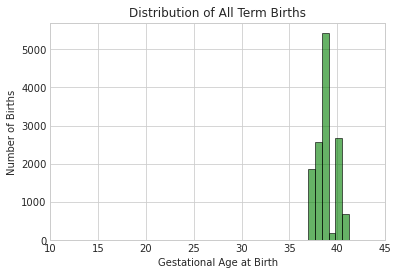

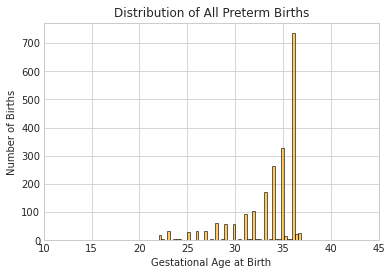

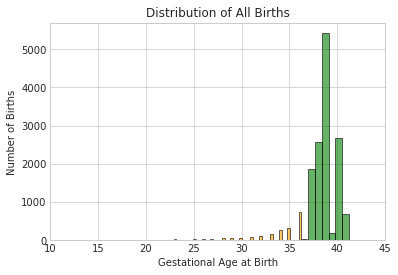

In [19]:
import matplotlib.pyplot as plt

# All Term Births
plt.style.use("seaborn-whitegrid")
term_cases = final_birth_data[final_birth_data['birth_class'] == 'Term']
plt.hist(term_cases['gestational_age_at_birth'], bins=10, alpha=0.6, color='green', edgecolor='black', label='All Term')
plt.xlabel('Gestational Age at Birth')
plt.ylabel('Number of Births')
plt.title('Distribution of All Term Births')
plt.xlim(10, 45) 
plt.show()


# All Preterm Births
non_term_cases = final_birth_data[final_birth_data['birth_class'] != 'Term']
plt.style.use("seaborn-whitegrid")
plt.hist(non_term_cases['gestational_age_at_birth'], bins=50, alpha=0.6, color='orange', edgecolor='black', label='All Preterm')
plt.xlabel('Gestational Age at Birth')
plt.ylabel('Number of Births')
plt.title('Distribution of All Preterm Births')
plt.xlim(10, 45) 
plt.show()


#All Births
plt.style.use("seaborn-whitegrid")
plt.hist(term_cases['gestational_age_at_birth'], bins=10, alpha=0.6, color='green', edgecolor='black', label='All Term')
plt.hist(non_term_cases['gestational_age_at_birth'], bins=50, alpha=0.6, color='orange', edgecolor='black', label='All Preterm')
plt.xlabel('Gestational Age at Birth')
plt.ylabel('Number of Births')
plt.title('Distribution of All Births')
plt.xlim(10, 45) 
plt.show()


In [32]:
#Don't forget to save your work to your local computer and push to GitHub.
#File -> Download as -> Notebook
#Move file from download folder to local repo clone
#git add filename.ipynb
#git commit -m "put a specific and informative message here of what you worked on"
#git push

# Importing the Data From All of Us

## Importing the Birth data

Note that data from *All of Us* is being imported into *Final_Birth_Concept_Set_for_Import* and cleaned there,
so the import takes some time (about 2 mins)

In [46]:
# As needed (i.e. once)
!pip install import-ipynb


[notice] A new release of pip available: 22.3.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [86]:
import import_ipynb
from Final_Birth_Concept_Set_for_Import import *

## Importing Age Data

In [87]:
final_birth_data.sample()

NameError: name 'final_birth_data' is not defined

In [36]:
import pandas
import os

# This query represents dataset "Birth_Diabetes_Test" for domain "person" and was generated for All of Us Controlled Tier Dataset v7
dataset_24817314_person_sql = """
    SELECT
        person.person_id,
        person.birth_datetime as date_of_birth 
    FROM
        `""" + os.environ["WORKSPACE_CDR"] + """.person` person   
    WHERE
        person.PERSON_ID IN (
            SELECT
                distinct person_id  
            FROM
                `""" + os.environ["WORKSPACE_CDR"] + """.cb_search_person` cb_search_person  
            WHERE
                cb_search_person.person_id IN (
                    SELECT
                        criteria.person_id 
                    FROM
                        (SELECT
                            DISTINCT person_id,
                            entry_date,
                            concept_id 
                        FROM
                            `""" + os.environ["WORKSPACE_CDR"] + """.cb_search_all_events` 
                        WHERE
                            (
                                concept_id IN (
                                    SELECT
                                        DISTINCT c.concept_id 
                                    FROM
                                        `""" + os.environ["WORKSPACE_CDR"] + """.cb_criteria` c 
                                    JOIN
                                        (
                                            select
                                                cast(cr.id as string) as id 
                                            FROM
                                                `""" + os.environ["WORKSPACE_CDR"] + """.cb_criteria` cr 
                                            WHERE
                                                concept_id IN (36712702, 45757176, 4014295) 
                                                AND full_text LIKE '%_rank1]%'
                                        ) a 
                                            ON (
                                                c.path LIKE CONCAT('%.',
                                            a.id,
                                            '.%') 
                                            OR c.path LIKE CONCAT('%.',
                                            a.id) 
                                            OR c.path LIKE CONCAT(a.id,
                                            '.%') 
                                            OR c.path = a.id) 
                                        WHERE
                                            is_standard = 1 
                                            AND is_selectable = 1
                                        ) 
                                        AND is_standard = 1 
                                )
                            ) criteria 
                        ) 
                        AND cb_search_person.person_id IN (
                            SELECT
                                criteria.person_id 
                            FROM
                                (SELECT
                                    DISTINCT person_id,
                                    entry_date,
                                    concept_id 
                                FROM
                                    `""" + os.environ["WORKSPACE_CDR"] + """.cb_search_all_events` 
                                WHERE
                                    (
                                        concept_id IN (903124) 
                                        AND is_standard = 0 
                                    )) criteria ) 
                        )"""

dataset_24817314_person_df = pandas.read_gbq(
    dataset_24817314_person_sql,
    dialect="standard",
    use_bqstorage_api=("BIGQUERY_STORAGE_API_ENABLED" in os.environ),
    progress_bar_type="tqdm_notebook")

dataset_24817314_person_df.head(5)

Downloading:   0%|          | 0/16016 [00:00<?, ?rows/s]

,person_id,date_of_birth
0,4721252,1987-06-15 00:00:00+00:00
1,1419254,2001-06-15 00:00:00+00:00
2,1192363,1971-06-15 00:00:00+00:00
3,1446224,1992-06-15 00:00:00+00:00
4,2764524,1979-06-15 00:00:00+00:00


## Importing the BMI Data

In [37]:
import pandas
import os

# This query represents dataset "Health Predictors (BMI, Smoking, Drinking)" for domain "measurement" and was generated for All of Us Controlled Tier Dataset v7
dataset_38394017_measurement_sql = """
    SELECT
        measurement.person_id,
        measurement.measurement_concept_id,
        m_standard_concept.concept_name as standard_concept_name,
        m_standard_concept.concept_code as standard_concept_code,
        m_standard_concept.vocabulary_id as standard_vocabulary,
        measurement.measurement_datetime,
        measurement.measurement_type_concept_id,
        m_type.concept_name as measurement_type_concept_name,
        measurement.operator_concept_id,
        m_operator.concept_name as operator_concept_name,
        measurement.value_as_number,
        measurement.value_as_concept_id,
        m_value.concept_name as value_as_concept_name,
        measurement.unit_concept_id,
        m_unit.concept_name as unit_concept_name,
        measurement.range_low,
        measurement.range_high,
        measurement.visit_occurrence_id,
        m_visit.concept_name as visit_occurrence_concept_name,
        measurement.measurement_source_value,
        measurement.measurement_source_concept_id,
        m_source_concept.concept_name as source_concept_name,
        m_source_concept.concept_code as source_concept_code,
        m_source_concept.vocabulary_id as source_vocabulary,
        measurement.unit_source_value,
        measurement.value_source_value 
    FROM
        ( SELECT
            * 
        FROM
            `""" + os.environ["WORKSPACE_CDR"] + """.measurement` measurement 
        WHERE
            (
                measurement_source_concept_id IN  (
                    SELECT
                        DISTINCT c.concept_id 
                    FROM
                        `""" + os.environ["WORKSPACE_CDR"] + """.cb_criteria` c 
                    JOIN
                        (
                            select
                                cast(cr.id as string) as id 
                            FROM
                                `""" + os.environ["WORKSPACE_CDR"] + """.cb_criteria` cr 
                            WHERE
                                concept_id IN (
                                    903124
                                ) 
                                AND full_text LIKE '%_rank1]%'
                        ) a 
                            ON (
                                c.path LIKE CONCAT('%.',
                            a.id,
                            '.%') 
                            OR c.path LIKE CONCAT('%.',
                            a.id) 
                            OR c.path LIKE CONCAT(a.id,
                            '.%') 
                            OR c.path = a.id) 
                        WHERE
                            is_standard = 0 
                            AND is_selectable = 1
                        )
                )  
                AND (
                    measurement.PERSON_ID IN (
                        SELECT
                            distinct person_id  
                        FROM
                            `""" + os.environ["WORKSPACE_CDR"] + """.cb_search_person` cb_search_person  
                        WHERE
                            cb_search_person.person_id IN (
                                SELECT
                                    criteria.person_id 
                                FROM
                                    (SELECT
                                        DISTINCT person_id,
                                        entry_date,
                                        concept_id 
                                    FROM
                                        `""" + os.environ["WORKSPACE_CDR"] + """.cb_search_all_events` 
                                    WHERE
                                        (
                                            concept_id IN (
                                                SELECT
                                                    DISTINCT c.concept_id 
                                                FROM
                                                    `""" + os.environ["WORKSPACE_CDR"] + """.cb_criteria` c 
                                                JOIN
                                                    (
                                                        select
                                                            cast(cr.id as string) as id 
                                                        FROM
                                                            `""" + os.environ["WORKSPACE_CDR"] + """.cb_criteria` cr 
                                                        WHERE
                                                            concept_id IN (36712702, 45757176, 4014295) 
                                                            AND full_text LIKE '%_rank1]%'
                                                    ) a 
                                                        ON (
                                                            c.path LIKE CONCAT('%.',
                                                        a.id,
                                                        '.%') 
                                                        OR c.path LIKE CONCAT('%.',
                                                        a.id) 
                                                        OR c.path LIKE CONCAT(a.id,
                                                        '.%') 
                                                        OR c.path = a.id) 
                                                    WHERE
                                                        is_standard = 1 
                                                        AND is_selectable = 1
                                                    ) 
                                                    AND is_standard = 1 
                                            )
                                        ) criteria 
                                    ) 
                                    AND cb_search_person.person_id IN (
                                        SELECT
                                            criteria.person_id 
                                        FROM
                                            (SELECT
                                                DISTINCT person_id,
                                                entry_date,
                                                concept_id 
                                            FROM
                                                `""" + os.environ["WORKSPACE_CDR"] + """.cb_search_all_events` 
                                            WHERE
                                                (
                                                    concept_id IN (903124) 
                                                    AND is_standard = 0 
                                                )) criteria ) 
                                    )
                                )) measurement 
                        LEFT JOIN
                            `""" + os.environ["WORKSPACE_CDR"] + """.concept` m_standard_concept 
                                ON measurement.measurement_concept_id = m_standard_concept.concept_id 
                        LEFT JOIN
                            `""" + os.environ["WORKSPACE_CDR"] + """.concept` m_type 
                                ON measurement.measurement_type_concept_id = m_type.concept_id 
                        LEFT JOIN
                            `""" + os.environ["WORKSPACE_CDR"] + """.concept` m_operator 
                                ON measurement.operator_concept_id = m_operator.concept_id 
                        LEFT JOIN
                            `""" + os.environ["WORKSPACE_CDR"] + """.concept` m_value 
                                ON measurement.value_as_concept_id = m_value.concept_id 
                        LEFT JOIN
                            `""" + os.environ["WORKSPACE_CDR"] + """.concept` m_unit 
                                ON measurement.unit_concept_id = m_unit.concept_id 
                        LEFT JOIn
                            `""" + os.environ["WORKSPACE_CDR"] + """.visit_occurrence` v 
                                ON measurement.visit_occurrence_id = v.visit_occurrence_id 
                        LEFT JOIN
                            `""" + os.environ["WORKSPACE_CDR"] + """.concept` m_visit 
                                ON v.visit_concept_id = m_visit.concept_id 
                        LEFT JOIN
                            `""" + os.environ["WORKSPACE_CDR"] + """.concept` m_source_concept 
                                ON measurement.measurement_source_concept_id = m_source_concept.concept_id"""

dataset_38394017_measurement_df = pandas.read_gbq(
    dataset_38394017_measurement_sql,
    dialect="standard",
    use_bqstorage_api=("BIGQUERY_STORAGE_API_ENABLED" in os.environ),
    progress_bar_type="tqdm_notebook")

dataset_38394017_measurement_df.head(5)

Downloading:   0%|          | 0/16016 [00:00<?, ?rows/s]

,person_id,measurement_concept_id,standard_concept_name,standard_concept_code,standard_vocabulary,measurement_datetime,measurement_type_concept_id,measurement_type_concept_name,operator_concept_id,operator_concept_name,...,range_high,visit_occurrence_id,visit_occurrence_concept_name,measurement_source_value,measurement_source_concept_id,source_concept_name,source_concept_code,source_vocabulary,unit_source_value,value_source_value
0,2395269,3038553,Body mass index (BMI) [Ratio],39156-5,LOINC,2018-05-22 21:39:43+00:00,44818701,From physical examination,0,No matching concept,...,NaN,1000000976290846,Outpatient Visit,bmi,903124,Computed body mass index,bmi,PPI,kg/m2,No matching concept
1,1613109,3038553,Body mass index (BMI) [Ratio],39156-5,LOINC,2019-03-26 20:22:45+00:00,44818701,From physical examination,0,No matching concept,...,NaN,1000000987069834,Outpatient Visit,bmi,903124,Computed body mass index,bmi,PPI,kg/m2,No matching concept
2,2617641,3038553,Body mass index (BMI) [Ratio],39156-5,LOINC,2019-07-23 14:34:37+00:00,44818701,From physical examination,0,No matching concept,...,NaN,1000000322196760,Outpatient Visit,bmi,903124,Computed body mass index,bmi,PPI,kg/m2,No matching concept
3,2373064,3038553,Body mass index (BMI) [Ratio],39156-5,LOINC,2021-11-30 16:18:58+00:00,44818701,From physical examination,0,No matching concept,...,NaN,1000000433604104,Outpatient Visit,bmi,903124,Computed body mass index,bmi,PPI,kg/m2,No matching concept
4,1252662,3038553,Body mass index (BMI) [Ratio],39156-5,LOINC,2019-02-01 19:10:26+00:00,44818701,From physical examination,0,No matching concept,...,NaN,1000000723869220,Outpatient Visit,bmi,903124,Computed body mass index,bmi,PPI,kg/m2,No matching concept


## Importing the Drinking Data

In [38]:
import pandas
import os

# This query represents dataset "Health Predictors (BMI, Smoking, Drinking)" for domain "survey" and was generated for All of Us Controlled Tier Dataset v7
dataset_38394017_survey_sql = """
    SELECT
        answer.person_id,
        answer.survey_datetime,
        answer.survey,
        answer.question_concept_id,
        answer.question,
        answer.answer_concept_id,
        answer.answer,
        answer.survey_version_concept_id,
        answer.survey_version_name  
    FROM
        `""" + os.environ["WORKSPACE_CDR"] + """.ds_survey` answer   
    WHERE
        (
            question_concept_id IN (
                1585636, 1586198, 1586201, 1586207, 1586213
            )
        )  
        AND (
            answer.PERSON_ID IN (
                SELECT
                    distinct person_id  
                FROM
                    `""" + os.environ["WORKSPACE_CDR"] + """.cb_search_person` cb_search_person  
                WHERE
                    cb_search_person.person_id IN (
                        SELECT
                            criteria.person_id 
                        FROM
                            (SELECT
                                DISTINCT person_id,
                                entry_date,
                                concept_id 
                            FROM
                                `""" + os.environ["WORKSPACE_CDR"] + """.cb_search_all_events` 
                            WHERE
                                (
                                    concept_id IN (
                                        SELECT
                                            DISTINCT c.concept_id 
                                        FROM
                                            `""" + os.environ["WORKSPACE_CDR"] + """.cb_criteria` c 
                                        JOIN
                                            (
                                                select
                                                    cast(cr.id as string) as id 
                                                FROM
                                                    `""" + os.environ["WORKSPACE_CDR"] + """.cb_criteria` cr 
                                                WHERE
                                                    concept_id IN (36712702, 45757176, 4014295) 
                                                    AND full_text LIKE '%_rank1]%'
                                            ) a 
                                                ON (
                                                    c.path LIKE CONCAT('%.',
                                                a.id,
                                                '.%') 
                                                OR c.path LIKE CONCAT('%.',
                                                a.id) 
                                                OR c.path LIKE CONCAT(a.id,
                                                '.%') 
                                                OR c.path = a.id) 
                                            WHERE
                                                is_standard = 1 
                                                AND is_selectable = 1
                                            ) 
                                            AND is_standard = 1 
                                    )
                                ) criteria 
                            ) 
                            AND cb_search_person.person_id IN (
                                SELECT
                                    criteria.person_id 
                                FROM
                                    (SELECT
                                        DISTINCT person_id,
                                        entry_date,
                                        concept_id 
                                    FROM
                                        `""" + os.environ["WORKSPACE_CDR"] + """.cb_search_all_events` 
                                    WHERE
                                        (
                                            concept_id IN (903124) 
                                            AND is_standard = 0 
                                        )) criteria ) 
                            )
                        )"""

dataset_38394017_survey_df = pandas.read_gbq(
    dataset_38394017_survey_sql,
    dialect="standard",
    use_bqstorage_api=("BIGQUERY_STORAGE_API_ENABLED" in os.environ),
    progress_bar_type="tqdm_notebook")

dataset_38394017_survey_df.head(5)

Downloading:   0%|          | 0/73363 [00:00<?, ?rows/s]

,person_id,survey_datetime,survey,question_concept_id,question,answer_concept_id,answer,survey_version_concept_id,survey_version_name
0,3064367,2018-09-19 21:49:50+00:00,Lifestyle,1586198,Alcohol: Alcohol Participant,903096,PMI: Skip,<NA>,None
1,1418414,2019-04-04 14:03:46+00:00,Lifestyle,1586198,Alcohol: Alcohol Participant,903096,PMI: Skip,<NA>,None
2,1088696,2017-10-11 14:53:55+00:00,Lifestyle,1586198,Alcohol: Alcohol Participant,903096,PMI: Skip,<NA>,None
3,1176154,2020-01-08 17:08:59+00:00,Lifestyle,1586198,Alcohol: Alcohol Participant,903096,PMI: Skip,<NA>,None
4,2703601,2018-10-30 15:52:12+00:00,Lifestyle,1586198,Alcohol: Alcohol Participant,1586200,Alcohol Participant: No,<NA>,None


## Importing the Smoking Data

In [39]:
import pandas
import os

# This query represents dataset "Health Predictors (BMI, Smoking, Drinking)" for domain "observation" and was generated for All of Us Controlled Tier Dataset v7
dataset_38394017_observation_sql = """
    SELECT
        observation.person_id,
        observation.observation_concept_id,
        o_standard_concept.concept_name as standard_concept_name,
        o_standard_concept.concept_code as standard_concept_code,
        o_standard_concept.vocabulary_id as standard_vocabulary,
        observation.observation_datetime,
        observation.observation_type_concept_id,
        o_type.concept_name as observation_type_concept_name,
        observation.value_as_number,
        observation.value_as_string,
        observation.value_as_concept_id,
        o_value.concept_name as value_as_concept_name,
        observation.qualifier_concept_id,
        o_qualifier.concept_name as qualifier_concept_name,
        observation.unit_concept_id,
        o_unit.concept_name as unit_concept_name,
        observation.visit_occurrence_id,
        o_visit.concept_name as visit_occurrence_concept_name,
        observation.observation_source_value,
        observation.observation_source_concept_id,
        o_source_concept.concept_name as source_concept_name,
        o_source_concept.concept_code as source_concept_code,
        o_source_concept.vocabulary_id as source_vocabulary,
        observation.unit_source_value,
        observation.qualifier_source_value,
        observation.value_source_concept_id,
        observation.value_source_value,
        observation.questionnaire_response_id 
    FROM
        ( SELECT
            * 
        FROM
            `""" + os.environ["WORKSPACE_CDR"] + """.observation` observation 
        WHERE
            (
                observation_concept_id IN (
                    4275495, 4276526, 43054909
                ) 
                OR  observation_source_concept_id IN (
                    1585636, 1586198, 1586201, 1586207, 1586213
                )
            )  
            AND (
                observation.PERSON_ID IN (
                    SELECT
                        distinct person_id  
                    FROM
                        `""" + os.environ["WORKSPACE_CDR"] + """.cb_search_person` cb_search_person  
                    WHERE
                        cb_search_person.person_id IN (
                            SELECT
                                criteria.person_id 
                            FROM
                                (SELECT
                                    DISTINCT person_id,
                                    entry_date,
                                    concept_id 
                                FROM
                                    `""" + os.environ["WORKSPACE_CDR"] + """.cb_search_all_events` 
                                WHERE
                                    (
                                        concept_id IN (
                                            SELECT
                                                DISTINCT c.concept_id 
                                            FROM
                                                `""" + os.environ["WORKSPACE_CDR"] + """.cb_criteria` c 
                                            JOIN
                                                (
                                                    select
                                                        cast(cr.id as string) as id 
                                                    FROM
                                                        `""" + os.environ["WORKSPACE_CDR"] + """.cb_criteria` cr 
                                                    WHERE
                                                        concept_id IN (36712702, 45757176, 4014295) 
                                                        AND full_text LIKE '%_rank1]%'
                                                ) a 
                                                    ON (
                                                        c.path LIKE CONCAT('%.',
                                                    a.id,
                                                    '.%') 
                                                    OR c.path LIKE CONCAT('%.',
                                                    a.id) 
                                                    OR c.path LIKE CONCAT(a.id,
                                                    '.%') 
                                                    OR c.path = a.id) 
                                                WHERE
                                                    is_standard = 1 
                                                    AND is_selectable = 1
                                                ) 
                                                AND is_standard = 1 
                                        )
                                    ) criteria 
                                ) 
                                AND cb_search_person.person_id IN (
                                    SELECT
                                        criteria.person_id 
                                    FROM
                                        (SELECT
                                            DISTINCT person_id,
                                            entry_date,
                                            concept_id 
                                        FROM
                                            `""" + os.environ["WORKSPACE_CDR"] + """.cb_search_all_events` 
                                        WHERE
                                            (
                                                concept_id IN (903124) 
                                                AND is_standard = 0 
                                            )) criteria ) 
                                )
                            )) observation 
                    LEFT JOIN
                        `""" + os.environ["WORKSPACE_CDR"] + """.concept` o_standard_concept 
                            ON observation.observation_concept_id = o_standard_concept.concept_id 
                    LEFT JOIN
                        `""" + os.environ["WORKSPACE_CDR"] + """.concept` o_type 
                            ON observation.observation_type_concept_id = o_type.concept_id 
                    LEFT JOIN
                        `""" + os.environ["WORKSPACE_CDR"] + """.concept` o_value 
                            ON observation.value_as_concept_id = o_value.concept_id 
                    LEFT JOIN
                        `""" + os.environ["WORKSPACE_CDR"] + """.concept` o_qualifier 
                            ON observation.qualifier_concept_id = o_qualifier.concept_id 
                    LEFT JOIN
                        `""" + os.environ["WORKSPACE_CDR"] + """.concept` o_unit 
                            ON observation.unit_concept_id = o_unit.concept_id 
                    LEFT JOIN
                        `""" + os.environ["WORKSPACE_CDR"] + """.visit_occurrence` v 
                            ON observation.visit_occurrence_id = v.visit_occurrence_id 
                    LEFT JOIN
                        `""" + os.environ["WORKSPACE_CDR"] + """.concept` o_visit 
                            ON v.visit_concept_id = o_visit.concept_id 
                    LEFT JOIN
                        `""" + os.environ["WORKSPACE_CDR"] + """.concept` o_source_concept 
                            ON observation.observation_source_concept_id = o_source_concept.concept_id"""

dataset_38394017_observation_df = pandas.read_gbq(
    dataset_38394017_observation_sql,
    dialect="standard",
    use_bqstorage_api=("BIGQUERY_STORAGE_API_ENABLED" in os.environ),
    progress_bar_type="tqdm_notebook")

dataset_38394017_observation_df.head(5)

Downloading:   0%|          | 0/263788 [00:00<?, ?rows/s]

,person_id,observation_concept_id,standard_concept_name,standard_concept_code,standard_vocabulary,observation_datetime,observation_type_concept_id,observation_type_concept_name,value_as_number,value_as_string,...,observation_source_value,observation_source_concept_id,source_concept_name,source_concept_code,source_vocabulary,unit_source_value,qualifier_source_value,value_source_concept_id,value_source_value,questionnaire_response_id
0,1176539,4275495,Tobacco smoking behavior - finding,365981007,SNOMED,2020-07-22 04:00:00+00:00,32865,Patient self-report,NaN,266919005,...,None,<NA>,None,None,None,None,None,<NA>,None,<NA>
1,1607689,4275495,Tobacco smoking behavior - finding,365981007,SNOMED,2015-03-16 04:00:00+00:00,32865,Patient self-report,NaN,8517006,...,None,<NA>,None,None,None,None,None,<NA>,None,<NA>
2,2058244,4275495,Tobacco smoking behavior - finding,365981007,SNOMED,2020-08-08 04:00:00+00:00,32865,Patient self-report,NaN,266919005,...,None,<NA>,None,None,None,None,None,<NA>,None,<NA>
3,1724092,4275495,Tobacco smoking behavior - finding,365981007,SNOMED,2020-04-17 04:00:00+00:00,32865,Patient self-report,NaN,266919005,...,None,<NA>,None,None,None,None,None,<NA>,None,<NA>
4,1792826,4275495,Tobacco smoking behavior - finding,365981007,SNOMED,2020-12-30 05:00:00+00:00,32865,Patient self-report,NaN,8517006,...,None,<NA>,None,None,None,None,None,<NA>,None,<NA>


## Importing the Diabetes Data

In [40]:
import pandas
import os

# This query represents dataset "Birth_Diabetes_Test" for domain "condition" and was generated for All of Us Controlled Tier Dataset v7
dataset_55961866_condition_sql = """
    SELECT
        c_occurrence.person_id,
        c_occurrence.condition_concept_id,
        c_standard_concept.concept_name as standard_concept_name,
        c_standard_concept.concept_code as standard_concept_code,
        c_standard_concept.vocabulary_id as standard_vocabulary,
        c_occurrence.condition_start_datetime,
        c_occurrence.condition_end_datetime,
        c_occurrence.condition_type_concept_id,
        c_type.concept_name as condition_type_concept_name,
        c_occurrence.stop_reason,
        c_occurrence.visit_occurrence_id,
        visit.concept_name as visit_occurrence_concept_name,
        c_occurrence.condition_source_value,
        c_occurrence.condition_source_concept_id,
        c_source_concept.concept_name as source_concept_name,
        c_source_concept.concept_code as source_concept_code,
        c_source_concept.vocabulary_id as source_vocabulary,
        c_occurrence.condition_status_source_value,
        c_occurrence.condition_status_concept_id,
        c_status.concept_name as condition_status_concept_name 
    FROM
        ( SELECT
            * 
        FROM
            `""" + os.environ["WORKSPACE_CDR"] + """.condition_occurrence` c_occurrence 
        WHERE
            (
                condition_concept_id IN  (
                    SELECT
                        DISTINCT c.concept_id 
                    FROM
                        `""" + os.environ["WORKSPACE_CDR"] + """.cb_criteria` c 
                    JOIN
                        (
                            select
                                cast(cr.id as string) as id 
                            FROM
                                `""" + os.environ["WORKSPACE_CDR"] + """.cb_criteria` cr 
                            WHERE
                                concept_id IN (
                                    201820, 201826, 37016349, 37311673
                                ) 
                                AND full_text LIKE '%_rank1]%'
                        ) a 
                            ON (
                                c.path LIKE CONCAT('%.',
                            a.id,
                            '.%') 
                            OR c.path LIKE CONCAT('%.',
                            a.id) 
                            OR c.path LIKE CONCAT(a.id,
                            '.%') 
                            OR c.path = a.id) 
                        WHERE
                            is_standard = 1 
                            AND is_selectable = 1
                        )
                )  
                AND (
                    c_occurrence.PERSON_ID IN (
                        SELECT
                            distinct person_id  
                        FROM
                            `""" + os.environ["WORKSPACE_CDR"] + """.cb_search_person` cb_search_person  
                        WHERE
                            cb_search_person.person_id IN (
                                SELECT
                                    criteria.person_id 
                                FROM
                                    (SELECT
                                        DISTINCT person_id,
                                        entry_date,
                                        concept_id 
                                    FROM
                                        `""" + os.environ["WORKSPACE_CDR"] + """.cb_search_all_events` 
                                    WHERE
                                        (
                                            concept_id IN (
                                                SELECT
                                                    DISTINCT c.concept_id 
                                                FROM
                                                    `""" + os.environ["WORKSPACE_CDR"] + """.cb_criteria` c 
                                                JOIN
                                                    (
                                                        select
                                                            cast(cr.id as string) as id 
                                                        FROM
                                                            `""" + os.environ["WORKSPACE_CDR"] + """.cb_criteria` cr 
                                                        WHERE
                                                            concept_id IN (36712702, 45757176, 4014295) 
                                                            AND full_text LIKE '%_rank1]%'
                                                    ) a 
                                                        ON (
                                                            c.path LIKE CONCAT('%.',
                                                        a.id,
                                                        '.%') 
                                                        OR c.path LIKE CONCAT('%.',
                                                        a.id) 
                                                        OR c.path LIKE CONCAT(a.id,
                                                        '.%') 
                                                        OR c.path = a.id) 
                                                    WHERE
                                                        is_standard = 1 
                                                        AND is_selectable = 1
                                                    ) 
                                                    AND is_standard = 1 
                                            )
                                        ) criteria 
                                    ) 
                                    AND cb_search_person.person_id IN (
                                        SELECT
                                            criteria.person_id 
                                        FROM
                                            (SELECT
                                                DISTINCT person_id,
                                                entry_date,
                                                concept_id 
                                            FROM
                                                `""" + os.environ["WORKSPACE_CDR"] + """.cb_search_all_events` 
                                            WHERE
                                                (
                                                    concept_id IN (903124) 
                                                    AND is_standard = 0 
                                                )) criteria ) 
                                    )
                                )) c_occurrence 
                        LEFT JOIN
                            `""" + os.environ["WORKSPACE_CDR"] + """.concept` c_standard_concept 
                                ON c_occurrence.condition_concept_id = c_standard_concept.concept_id 
                        LEFT JOIN
                            `""" + os.environ["WORKSPACE_CDR"] + """.concept` c_type 
                                ON c_occurrence.condition_type_concept_id = c_type.concept_id 
                        LEFT JOIN
                            `""" + os.environ["WORKSPACE_CDR"] + """.visit_occurrence` v 
                                ON c_occurrence.visit_occurrence_id = v.visit_occurrence_id 
                        LEFT JOIN
                            `""" + os.environ["WORKSPACE_CDR"] + """.concept` visit 
                                ON v.visit_concept_id = visit.concept_id 
                        LEFT JOIN
                            `""" + os.environ["WORKSPACE_CDR"] + """.concept` c_source_concept 
                                ON c_occurrence.condition_source_concept_id = c_source_concept.concept_id 
                        LEFT JOIN
                            `""" + os.environ["WORKSPACE_CDR"] + """.concept` c_status 
                                ON c_occurrence.condition_status_concept_id = c_status.concept_id"""

dataset_55961866_condition_df = pandas.read_gbq(
    dataset_55961866_condition_sql,
    dialect="standard",
    use_bqstorage_api=("BIGQUERY_STORAGE_API_ENABLED" in os.environ),
    progress_bar_type="tqdm_notebook")

dataset_55961866_condition_df.head(10)

Downloading:   0%|          | 0/109418 [00:00<?, ?rows/s]

,person_id,condition_concept_id,standard_concept_name,standard_concept_code,standard_vocabulary,condition_start_datetime,condition_end_datetime,condition_type_concept_id,condition_type_concept_name,stop_reason,visit_occurrence_id,visit_occurrence_concept_name,condition_source_value,condition_source_concept_id,source_concept_name,source_concept_code,source_vocabulary,condition_status_source_value,condition_status_concept_id,condition_status_concept_name
0,2328300,201826,Type 2 diabetes mellitus,44054006,SNOMED,2020-07-06 00:00:00+00:00,2020-07-06 11:59:59+00:00,44786629,Secondary Condition,None,27000000004843796,Inpatient Visit,E11.52,45533022,Type 2 diabetes mellitus with diabetic periphe...,E11.52,ICD10CM,None,<NA>,None
1,2328300,201826,Type 2 diabetes mellitus,44054006,SNOMED,2020-11-11 00:00:00+00:00,2020-11-11 11:59:59+00:00,44786629,Secondary Condition,None,27000000001505044,Inpatient Visit,E11.52,45533022,Type 2 diabetes mellitus with diabetic periphe...,E11.52,ICD10CM,None,<NA>,None
2,2328300,201826,Type 2 diabetes mellitus,44054006,SNOMED,2019-10-01 00:00:00+00:00,2019-10-01 11:59:59+00:00,0,No matching concept,None,27000000000548256,Inpatient Visit,E11.52,45533022,Type 2 diabetes mellitus with diabetic periphe...,E11.52,ICD10CM,None,<NA>,None
3,2198153,192691,Diabetes mellitus during pregnancy - baby not ...,199227004,SNOMED,2019-05-31 00:00:00+00:00,NaT,44786627,Primary Condition,None,44000000000760584,Outpatient Visit,199227004,192691,Diabetes mellitus during pregnancy - baby not ...,199227004,SNOMED,None,<NA>,None
4,2328300,201826,Type 2 diabetes mellitus,44054006,SNOMED,2019-07-10 16:06:00+00:00,2019-07-10 11:59:59+00:00,44786629,Secondary Condition,None,27000000005679768,Outpatient Visit,E11.52,45533022,Type 2 diabetes mellitus with diabetic periphe...,E11.52,ICD10CM,None,<NA>,None
5,2202313,201826,Type 2 diabetes mellitus,44054006,SNOMED,2018-06-25 00:00:00+00:00,NaT,44786629,Secondary Condition,None,31000000048582520,None,E11.22,45595797,Type 2 diabetes mellitus with diabetic chronic...,E11.22,ICD10CM,None,<NA>,None
6,2258236,201826,Type 2 diabetes mellitus,44054006,SNOMED,2019-06-30 00:00:00+00:00,2019-07-11 11:59:59+00:00,44786629,Secondary Condition,None,27000000005773952,Inpatient Visit,E11.22,45595797,Type 2 diabetes mellitus with diabetic chronic...,E11.22,ICD10CM,None,<NA>,None
7,2898646,201826,Type 2 diabetes mellitus,44054006,SNOMED,2020-11-24 00:00:00+00:00,2020-11-24 11:59:59+00:00,44786629,Secondary Condition,None,27000000005972932,Inpatient Visit,E11.22,45595797,Type 2 diabetes mellitus with diabetic chronic...,E11.22,ICD10CM,None,<NA>,None
8,2898646,201826,Type 2 diabetes mellitus,44054006,SNOMED,2020-12-01 00:00:00+00:00,2020-12-01 11:59:59+00:00,44786629,Secondary Condition,None,27000000005972932,Inpatient Visit,E11.22,45595797,Type 2 diabetes mellitus with diabetic chronic...,E11.22,ICD10CM,None,<NA>,None
9,2328300,201826,Type 2 diabetes mellitus,44054006,SNOMED,2019-09-30 00:00:00+00:00,2019-10-11 11:59:59+00:00,44786629,Secondary Condition,None,27000000008235272,Inpatient Visit,E11.22,45595797,Type 2 diabetes mellitus with diabetic chronic...,E11.22,ICD10CM,None,<NA>,None


## Importing the Depression & Anxiety Data

In [41]:
import pandas
import os

# This query represents dataset "Birth_Depression_Anxiety" for domain "condition" and was generated for All of Us Controlled Tier Dataset v7
dataset_79875266_condition_sql = """
    SELECT
        c_occurrence.person_id,
        c_occurrence.condition_concept_id,
        c_standard_concept.concept_name as standard_concept_name,
        c_standard_concept.concept_code as standard_concept_code,
        c_standard_concept.vocabulary_id as standard_vocabulary,
        c_occurrence.condition_start_datetime,
        c_occurrence.condition_end_datetime,
        c_occurrence.condition_type_concept_id,
        c_type.concept_name as condition_type_concept_name,
        c_occurrence.stop_reason,
        c_occurrence.visit_occurrence_id,
        visit.concept_name as visit_occurrence_concept_name,
        c_occurrence.condition_source_value,
        c_occurrence.condition_source_concept_id,
        c_source_concept.concept_name as source_concept_name,
        c_source_concept.concept_code as source_concept_code,
        c_source_concept.vocabulary_id as source_vocabulary,
        c_occurrence.condition_status_source_value,
        c_occurrence.condition_status_concept_id,
        c_status.concept_name as condition_status_concept_name 
    FROM
        ( SELECT
            * 
        FROM
            `""" + os.environ["WORKSPACE_CDR"] + """.condition_occurrence` c_occurrence 
        WHERE
            (
                condition_concept_id IN  (
                    SELECT
                        DISTINCT c.concept_id 
                    FROM
                        `""" + os.environ["WORKSPACE_CDR"] + """.cb_criteria` c 
                    JOIN
                        (
                            select
                                cast(cr.id as string) as id 
                            FROM
                                `""" + os.environ["WORKSPACE_CDR"] + """.cb_criteria` cr 
                            WHERE
                                concept_id IN (
                                    440383, 442077
                                ) 
                                AND full_text LIKE '%_rank1]%'
                        ) a 
                            ON (
                                c.path LIKE CONCAT('%.',
                            a.id,
                            '.%') 
                            OR c.path LIKE CONCAT('%.',
                            a.id) 
                            OR c.path LIKE CONCAT(a.id,
                            '.%') 
                            OR c.path = a.id) 
                        WHERE
                            is_standard = 1 
                            AND is_selectable = 1
                        )
                )  
                AND (
                    c_occurrence.PERSON_ID IN (
                        SELECT
                            distinct person_id  
                        FROM
                            `""" + os.environ["WORKSPACE_CDR"] + """.cb_search_person` cb_search_person  
                        WHERE
                            cb_search_person.person_id IN (
                                SELECT
                                    criteria.person_id 
                                FROM
                                    (SELECT
                                        DISTINCT person_id,
                                        entry_date,
                                        concept_id 
                                    FROM
                                        `""" + os.environ["WORKSPACE_CDR"] + """.cb_search_all_events` 
                                    WHERE
                                        (
                                            concept_id IN (
                                                SELECT
                                                    DISTINCT c.concept_id 
                                                FROM
                                                    `""" + os.environ["WORKSPACE_CDR"] + """.cb_criteria` c 
                                                JOIN
                                                    (
                                                        select
                                                            cast(cr.id as string) as id 
                                                        FROM
                                                            `""" + os.environ["WORKSPACE_CDR"] + """.cb_criteria` cr 
                                                        WHERE
                                                            concept_id IN (36712702, 45757176, 4014295) 
                                                            AND full_text LIKE '%_rank1]%'
                                                    ) a 
                                                        ON (
                                                            c.path LIKE CONCAT('%.',
                                                        a.id,
                                                        '.%') 
                                                        OR c.path LIKE CONCAT('%.',
                                                        a.id) 
                                                        OR c.path LIKE CONCAT(a.id,
                                                        '.%') 
                                                        OR c.path = a.id) 
                                                    WHERE
                                                        is_standard = 1 
                                                        AND is_selectable = 1
                                                    ) 
                                                    AND is_standard = 1 
                                            )
                                        ) criteria 
                                    ) 
                                    AND cb_search_person.person_id IN (
                                        SELECT
                                            criteria.person_id 
                                        FROM
                                            (SELECT
                                                DISTINCT person_id,
                                                entry_date,
                                                concept_id 
                                            FROM
                                                `""" + os.environ["WORKSPACE_CDR"] + """.cb_search_all_events` 
                                            WHERE
                                                (
                                                    concept_id IN (903124) 
                                                    AND is_standard = 0 
                                                )) criteria ) 
                                    )
                                )) c_occurrence 
                        LEFT JOIN
                            `""" + os.environ["WORKSPACE_CDR"] + """.concept` c_standard_concept 
                                ON c_occurrence.condition_concept_id = c_standard_concept.concept_id 
                        LEFT JOIN
                            `""" + os.environ["WORKSPACE_CDR"] + """.concept` c_type 
                                ON c_occurrence.condition_type_concept_id = c_type.concept_id 
                        LEFT JOIN
                            `""" + os.environ["WORKSPACE_CDR"] + """.visit_occurrence` v 
                                ON c_occurrence.visit_occurrence_id = v.visit_occurrence_id 
                        LEFT JOIN
                            `""" + os.environ["WORKSPACE_CDR"] + """.concept` visit 
                                ON v.visit_concept_id = visit.concept_id 
                        LEFT JOIN
                            `""" + os.environ["WORKSPACE_CDR"] + """.concept` c_source_concept 
                                ON c_occurrence.condition_source_concept_id = c_source_concept.concept_id 
                        LEFT JOIN
                            `""" + os.environ["WORKSPACE_CDR"] + """.concept` c_status 
                                ON c_occurrence.condition_status_concept_id = c_status.concept_id"""

dataset_79875266_condition_df = pandas.read_gbq(
    dataset_79875266_condition_sql,
    dialect="standard",
    use_bqstorage_api=("BIGQUERY_STORAGE_API_ENABLED" in os.environ),
    progress_bar_type="tqdm_notebook")

dataset_79875266_condition_df.head(10)

Downloading:   0%|          | 0/240666 [00:00<?, ?rows/s]

,person_id,condition_concept_id,standard_concept_name,standard_concept_code,standard_vocabulary,condition_start_datetime,condition_end_datetime,condition_type_concept_id,condition_type_concept_name,stop_reason,visit_occurrence_id,visit_occurrence_concept_name,condition_source_value,condition_source_concept_id,source_concept_name,source_concept_code,source_vocabulary,condition_status_source_value,condition_status_concept_id,condition_status_concept_name
0,1386469,442077,Anxiety disorder,197480006,SNOMED,2007-02-28 00:00:00+00:00,NaT,44786629,Secondary Condition,None,31000000049271976,Office Visit,300.00,44832239,"Anxiety state, unspecified",300.00,ICD9CM,None,<NA>,None
1,1337774,4077577,Moderate recurrent major depression,18818009,SNOMED,2021-11-11 00:00:00+00:00,NaT,44786627,Primary Condition,None,44000000001149608,Outpatient Visit,18818009,4077577,Moderate recurrent major depression,18818009,SNOMED,None,<NA>,None
2,2201351,4228802,Mild recurrent major depression,40379007,SNOMED,2019-02-14 00:00:00+00:00,NaT,44786627,Primary Condition,None,44000000001550816,Outpatient Visit,40379007,4228802,Mild recurrent major depression,40379007,SNOMED,None,<NA>,None
3,2473476,4228802,Mild recurrent major depression,40379007,SNOMED,2015-05-14 00:00:00+00:00,NaT,0,No matching concept,None,44000000000456728,Outpatient Visit,40379007,4228802,Mild recurrent major depression,40379007,SNOMED,None,<NA>,None
4,1653587,441534,"Severe major depression, single episode, witho...",76441001,SNOMED,2016-11-11 00:00:00+00:00,2016-11-11 11:59:59+00:00,44786629,Secondary Condition,None,27000000005930596,Outpatient Visit,F32.2,35207152,"Major depressive disorder, single episode, sev...",F32.2,ICD10CM,None,<NA>,None
5,3464259,441534,"Severe major depression, single episode, witho...",76441001,SNOMED,2021-03-29 11:51:00+00:00,2021-03-29 11:59:59+00:00,44786629,Secondary Condition,None,27000000007061792,Outpatient Visit,F32.2,35207152,"Major depressive disorder, single episode, sev...",F32.2,ICD10CM,None,<NA>,None
6,2047298,441534,"Severe major depression, single episode, witho...",76441001,SNOMED,2022-05-26 00:00:00+00:00,2022-05-26 11:59:59+00:00,44786627,Primary Condition,None,27000000002402732,Outpatient Visit,F32.2,35207152,"Major depressive disorder, single episode, sev...",F32.2,ICD10CM,None,<NA>,None
7,3464259,441534,"Severe major depression, single episode, witho...",76441001,SNOMED,2021-04-26 15:47:00+00:00,2021-04-26 11:59:59+00:00,44786629,Secondary Condition,None,27000000007928776,Outpatient Visit,F32.2,35207152,"Major depressive disorder, single episode, sev...",F32.2,ICD10CM,None,<NA>,None
8,2363515,439253,"Bipolar affective disorder, currently depresse...",191629006,SNOMED,2020-06-16 00:00:00+00:00,2020-06-16 11:59:59+00:00,44786629,Secondary Condition,None,27000000004469444,Outpatient Visit,F31.31,45566839,"Bipolar disorder, current episode depressed, mild",F31.31,ICD10CM,None,<NA>,None
9,1776602,439254,"Bipolar affective disorder, current episode de...",191627008,SNOMED,2017-10-20 00:00:00+00:00,2017-10-20 11:59:59+00:00,0,No matching concept,None,27000000002031976,Outpatient Visit,F31.30,45571756,"Bipolar disorder, current episode depressed, m...",F31.30,ICD10CM,None,<NA>,None


## Importing the Drug Abuse Data

In [42]:
import pandas
import os

# This query represents dataset "Birth_Drug_Abuse" for domain "condition" and was generated for All of Us Controlled Tier Dataset v7
dataset_07549439_condition_sql = """
    SELECT
        c_occurrence.person_id,
        c_occurrence.condition_concept_id,
        c_standard_concept.concept_name as standard_concept_name,
        c_standard_concept.concept_code as standard_concept_code,
        c_standard_concept.vocabulary_id as standard_vocabulary,
        c_occurrence.condition_start_datetime,
        c_occurrence.condition_end_datetime,
        c_occurrence.condition_type_concept_id,
        c_type.concept_name as condition_type_concept_name,
        c_occurrence.stop_reason,
        c_occurrence.visit_occurrence_id,
        visit.concept_name as visit_occurrence_concept_name,
        c_occurrence.condition_source_value,
        c_occurrence.condition_source_concept_id,
        c_source_concept.concept_name as source_concept_name,
        c_source_concept.concept_code as source_concept_code,
        c_source_concept.vocabulary_id as source_vocabulary,
        c_occurrence.condition_status_source_value,
        c_occurrence.condition_status_concept_id,
        c_status.concept_name as condition_status_concept_name 
    FROM
        ( SELECT
            * 
        FROM
            `""" + os.environ["WORKSPACE_CDR"] + """.condition_occurrence` c_occurrence 
        WHERE
            (
                condition_concept_id IN  (
                    SELECT
                        DISTINCT c.concept_id 
                    FROM
                        `""" + os.environ["WORKSPACE_CDR"] + """.cb_criteria` c 
                    JOIN
                        (
                            select
                                cast(cr.id as string) as id 
                            FROM
                                `""" + os.environ["WORKSPACE_CDR"] + """.cb_criteria` cr 
                            WHERE
                                concept_id IN (
                                    436954
                                ) 
                                AND full_text LIKE '%_rank1]%'
                        ) a 
                            ON (
                                c.path LIKE CONCAT('%.',
                            a.id,
                            '.%') 
                            OR c.path LIKE CONCAT('%.',
                            a.id) 
                            OR c.path LIKE CONCAT(a.id,
                            '.%') 
                            OR c.path = a.id) 
                        WHERE
                            is_standard = 1 
                            AND is_selectable = 1
                        )
                )  
                AND (
                    c_occurrence.PERSON_ID IN (
                        SELECT
                            distinct person_id  
                        FROM
                            `""" + os.environ["WORKSPACE_CDR"] + """.cb_search_person` cb_search_person  
                        WHERE
                            cb_search_person.person_id IN (
                                SELECT
                                    criteria.person_id 
                                FROM
                                    (SELECT
                                        DISTINCT person_id,
                                        entry_date,
                                        concept_id 
                                    FROM
                                        `""" + os.environ["WORKSPACE_CDR"] + """.cb_search_all_events` 
                                    WHERE
                                        (
                                            concept_id IN (
                                                SELECT
                                                    DISTINCT c.concept_id 
                                                FROM
                                                    `""" + os.environ["WORKSPACE_CDR"] + """.cb_criteria` c 
                                                JOIN
                                                    (
                                                        select
                                                            cast(cr.id as string) as id 
                                                        FROM
                                                            `""" + os.environ["WORKSPACE_CDR"] + """.cb_criteria` cr 
                                                        WHERE
                                                            concept_id IN (36712702, 45757176, 4014295) 
                                                            AND full_text LIKE '%_rank1]%'
                                                    ) a 
                                                        ON (
                                                            c.path LIKE CONCAT('%.',
                                                        a.id,
                                                        '.%') 
                                                        OR c.path LIKE CONCAT('%.',
                                                        a.id) 
                                                        OR c.path LIKE CONCAT(a.id,
                                                        '.%') 
                                                        OR c.path = a.id) 
                                                    WHERE
                                                        is_standard = 1 
                                                        AND is_selectable = 1
                                                    ) 
                                                    AND is_standard = 1 
                                            )
                                        ) criteria 
                                    ) 
                                    AND cb_search_person.person_id IN (
                                        SELECT
                                            criteria.person_id 
                                        FROM
                                            (SELECT
                                                DISTINCT person_id,
                                                entry_date,
                                                concept_id 
                                            FROM
                                                `""" + os.environ["WORKSPACE_CDR"] + """.cb_search_all_events` 
                                            WHERE
                                                (
                                                    concept_id IN (903124) 
                                                    AND is_standard = 0 
                                                )) criteria ) 
                                    )
                                )) c_occurrence 
                        LEFT JOIN
                            `""" + os.environ["WORKSPACE_CDR"] + """.concept` c_standard_concept 
                                ON c_occurrence.condition_concept_id = c_standard_concept.concept_id 
                        LEFT JOIN
                            `""" + os.environ["WORKSPACE_CDR"] + """.concept` c_type 
                                ON c_occurrence.condition_type_concept_id = c_type.concept_id 
                        LEFT JOIN
                            `""" + os.environ["WORKSPACE_CDR"] + """.visit_occurrence` v 
                                ON c_occurrence.visit_occurrence_id = v.visit_occurrence_id 
                        LEFT JOIN
                            `""" + os.environ["WORKSPACE_CDR"] + """.concept` visit 
                                ON v.visit_concept_id = visit.concept_id 
                        LEFT JOIN
                            `""" + os.environ["WORKSPACE_CDR"] + """.concept` c_source_concept 
                                ON c_occurrence.condition_source_concept_id = c_source_concept.concept_id 
                        LEFT JOIN
                            `""" + os.environ["WORKSPACE_CDR"] + """.concept` c_status 
                                ON c_occurrence.condition_status_concept_id = c_status.concept_id"""

dataset_07549439_condition_df = pandas.read_gbq(
    dataset_07549439_condition_sql,
    dialect="standard",
    use_bqstorage_api=("BIGQUERY_STORAGE_API_ENABLED" in os.environ),
    progress_bar_type="tqdm_notebook")

dataset_07549439_condition_df.head(5)

Downloading:   0%|          | 0/3526 [00:00<?, ?rows/s]

,person_id,condition_concept_id,standard_concept_name,standard_concept_code,standard_vocabulary,condition_start_datetime,condition_end_datetime,condition_type_concept_id,condition_type_concept_name,stop_reason,visit_occurrence_id,visit_occurrence_concept_name,condition_source_value,condition_source_concept_id,source_concept_name,source_concept_code,source_vocabulary,condition_status_source_value,condition_status_concept_id,condition_status_concept_name
0,3223096,43530681,Drug abuse in remission,1471000119103,SNOMED,2018-05-07 00:00:00+00:00,NaT,44786627,Primary Condition,None,44000000000865368,Outpatient Visit,305.23,44829937,"Cannabis abuse, in remission",305.23,ICD9CM,None,<NA>,None
1,3277521,4145220,"Drug abuse, continuous",426590003,SNOMED,2011-07-14 06:00:00+00:00,NaT,32821,EHR billing record,None,42000000065349256,Emergency Room Visit,305.01,44826518,"Alcohol abuse, continuous",305.01,ICD9CM,None,<NA>,None
2,1772600,43530681,Drug abuse in remission,1471000119103,SNOMED,2013-02-07 00:00:00+00:00,2013-02-07 11:59:59+00:00,44786629,Secondary Condition,None,27000000004115072,Outpatient Visit,305.93,44831108,"Other, mixed, or unspecified drug abuse, in re...",305.93,ICD9CM,None,<NA>,None
3,1258544,43530681,Drug abuse in remission,1471000119103,SNOMED,2016-09-27 00:00:00+00:00,NaT,44786629,Secondary Condition,None,9000000005099917,Office Visit,305.93,44831108,"Other, mixed, or unspecified drug abuse, in re...",305.93,ICD9CM,None,<NA>,None
4,3505972,43530681,Drug abuse in remission,1471000119103,SNOMED,2016-03-23 00:00:00+00:00,NaT,44786627,Primary Condition,None,9000000002712658,Office Visit,305.73,44829941,Amphetamine or related acting sympathomimetic ...,305.73,ICD9CM,None,<NA>,None


# Combining each data frame into a single data frame

## Importing needed packages

In [12]:
import pandas as pd

## Renaming individual data frames and dropping columns we don't need

In [51]:
# condition_df

#condition_df = final_birth_data



# dob_df (date of birth)

dob_df = dataset_24817314_person_df



# bmi_df

bmi_df_drop_columns = dataset_38394017_measurement_df.columns.tolist()


bmi_df_drop_columns.remove('person_id')
bmi_df_drop_columns.remove('value_as_number')
# bmi_df_drop_columns.remove('range_low') - upon investigation, not helpful
# bmi_df_drop_columns.remove('range_high') - upon investigation, not helpful
# bmi_df_drop_columns.remove('unit_source_value') - confirmed all observations using same units (kg/m^2)

bmi_df = dataset_38394017_measurement_df.drop(columns=bmi_df_drop_columns).rename(columns={'value_as_number':'BMI'}).copy()



# drinking_df

drinking_df_drop_columns = dataset_38394017_survey_df.columns.tolist()

drinking_df_drop_columns.remove('person_id')
drinking_df_drop_columns.remove('question')
drinking_df_drop_columns.remove('answer')

drinking_df = dataset_38394017_survey_df.drop(columns=drinking_df_drop_columns).copy()



# smoking_df

smoking_df_drop_columns = dataset_38394017_observation_df.columns.tolist()

smoking_df_drop_columns.remove('person_id')
smoking_df_drop_columns.remove('standard_concept_name')
#smoking_df_drop_columns.remove('observation_datetime') - won't be able to use for all data
#smoking_df_drop_columns.remove('observation_type_concept_name') - won't be able to use for all data
smoking_df_drop_columns.remove('value_as_concept_name')
#smoking_df_drop_columns.remove('visit_occurrence_concept_name') - won't be able to use for all data
#smoking_df_drop_columns.remove('source_concept_name') - won't be able to use for all data

smoking_df = dataset_38394017_observation_df.drop(columns=smoking_df_drop_columns).copy()



# diabetes_df
diabetes_df_drop_columns = dataset_55961866_condition_df.columns.tolist()

diabetes_df_drop_columns.remove('person_id')
diabetes_df_drop_columns.remove('standard_concept_name')
diabetes_df_drop_columns.remove('condition_start_datetime') # could also include condition_end_datetime?

diabetes_df = dataset_55961866_condition_df.drop(columns=diabetes_df_drop_columns).copy()


# mental_df (depression & anxiety)
mental_df_drop_columns = dataset_79875266_condition_df.columns.tolist()

mental_df_drop_columns.remove('person_id')
mental_df_drop_columns.remove('standard_concept_name')
mental_df_drop_columns.remove('condition_start_datetime')

mental_df = dataset_79875266_condition_df.drop(columns=mental_df_drop_columns).copy()


# drug_df (drug abuse)
drug_df_drop_columns = dataset_07549439_condition_df.columns.tolist()

drug_df_drop_columns.remove('person_id')
drug_df_drop_columns.remove('standard_concept_name')
drug_df_drop_columns.remove('condition_start_datetime')

drug_df = dataset_07549439_condition_df.drop(columns=mental_df_drop_columns).copy()

## Finding common values of *person_id* and restricting data frames to rows with common values

In [89]:
# create a dictionary of values of person_id and multiplicities in each data frame

## start by creating sets of unique ids

unique_ids_condition = list(condition_df.person_id.unique())
unique_ids_dob = list(dob_df.person_id.unique())
unique_ids_bmi = list(bmi_df.person_id.unique())
unique_ids_drinking = list(drinking_df.person_id.unique())
unique_ids_smoking = list(smoking_df.person_id.unique())

In [90]:
## create a set of values of person_id that occur in each data frame
## we then sort common_ids in ascending order

## since we only have four data frames, easy to construct full hierarchy, if we want

common_ids = []

# Note: not including diabetes_df or mental_df here because it restricts the number of entries & we are 
# assuming that people not in these data frames don't have the condition
for pid in unique_ids_condition:
    if (pid in unique_ids_dob) and (pid in unique_ids_bmi) and (pid in unique_ids_drinking) and (pid in unique_ids_smoking):
        common_ids.append(pid)

common_ids.sort()


In [91]:
## restrict data frames to rows with personal_id values in common_ids
## Also, we sort by person_id

## For restricted condition, we primarily sort by person_id, but
## for each value of person_id, we then sort by birth order

restricted_condition = condition_df[condition_df["person_id"].isin(common_ids)].copy().sort_values(by=["person_id", "birth_order"])
restricted_dob = dob_df[dob_df["person_id"].isin(common_ids)].copy().sort_values(by=["person_id"])
restricted_bmi = bmi_df[bmi_df["person_id"].isin(common_ids)].copy().sort_values(by=["person_id"])
restricted_drinking = drinking_df[drinking_df["person_id"].isin(common_ids)].copy().sort_values(by=["person_id"])
restricted_smoking = smoking_df[smoking_df["person_id"].isin(common_ids)].copy().sort_values(by=["person_id"])

In [94]:
# Check shapes of each df
print(restricted_condition.shape)
print(restricted_dob.shape)
print(restricted_bmi.shape)
print(restricted_drinking.shape)
print(restricted_smoking.shape)

(13697, 5)
(10588, 2)
(10588, 2)
(47849, 3)
(161719, 3)


## Splitting up restricted data frames

We will break up `restricted_condition` by `birth_order`, `restricted_drinking` by `question`, and `restricted_smoking` by `standard_concept_name`

### We start by splitting up *restricted_condition* by *birth_order*

In [95]:
## Note that as of 17 Nov 2023, we see
## Everyone (10588) has a first birth
## 2703 out of 10588 have a second birth
## 374 out of 10588 have a third birth
## 31 out of 10588 have a fourth birth
## 1 out of 10588 have a fifth birth
## For run time concerns, we only include first, second, and third births

first_birth = restricted_condition[restricted_condition['birth_order'] == 1].copy().sort_values(by=["person_id"])
second_birth = restricted_condition[restricted_condition['birth_order'] == 2].copy().sort_values(by=["person_id"])
third_birth = restricted_condition[restricted_condition['birth_order'] == 3].copy().sort_values(by=["person_id"])

### Then, we calculate maternal age for each birth using `restricted_age`

### Next, we break up `restricted_drinking` by question

We split up `restricted_drinking` by the four questions asked, which approximately are:
1) Have you ever drank alcohol (aside from a sip or taste)?  
2) How frequently do you drink?  
3) How many drinks do you have daily, on average?  
4) How many times in the past year have you had six or more drinks?  

We then drop the question column and rename the answer column in each case.

Finally, since not all values of `person_id` answer every question, we make a new list of values of `person_id` which do answer every question in `restricted_drinking`. Note that everyone has answered question 1.

Also, since there are only two responses (yes and no) to question 1, we also create a binary version of the responses

In [96]:
drinking_part = restricted_drinking[restricted_drinking['question'] == 'Alcohol: Alcohol Participant'].copy().sort_values(by=['person_id'])

drinking_freq = restricted_drinking[restricted_drinking['question'] == 'Alcohol: Drink Frequency Past Year'].copy().sort_values(by=['person_id'])

drinking_avg = restricted_drinking[restricted_drinking['question'] == 'Alcohol: Average Daily Drink Count'].copy().sort_values(by=['person_id'])

drinking_six = restricted_drinking[restricted_drinking['question'] == 'Alcohol: 6 or More Drinks Occurrence'].copy().sort_values(by=['person_id'])

In [97]:
drinking_part = drinking_part.drop(columns=['question']).copy()
drinking_part = drinking_part.rename(columns={'answer':'ever_drank_alcohol'})
drinking_part.loc[:,'ever_drank_alcohol_binary'] = pd.get_dummies(drinking_part['ever_drank_alcohol'])['Alcohol Participant: Yes'].copy()

drinking_freq = drinking_freq.drop(columns=['question']).copy()
drinking_freq = drinking_freq.rename(columns={'answer':'drinking_frequency'})

drinking_avg = drinking_avg.drop(columns=['question']).copy()
drinking_avg = drinking_avg.rename(columns={'answer':'daily_drink_count'})

drinking_six = drinking_six.drop(columns=['question']).copy()
drinking_six = drinking_six.rename(columns={'answer':'six_or_more_drinks_occurrence'})

In [98]:
drinking_ids = []

freq_ids = drinking_freq.person_id.tolist()
avg_ids = drinking_avg.person_id.tolist()
six_ids = drinking_six.person_id.tolist()

for pid in common_ids:
    if (pid in freq_ids) and (pid in avg_ids) and (pid in six_ids):
        drinking_ids.append(pid)

drinking_ids.sort()

### Next, we handle `restricted_smoking`

The `restricted_smoking` has several values of `standard_concept_name` of interest, namely:
1) Tobacco smoking behavior - finding   
2) Tobacco smoking status  
3) Cigarette smoker  

Note, many values of `person_id` have multiple responses for each. As a result, we build our own feature which records if a value of `person_id` has ever been a smoker.

Also, 3 has many fewer values than 1 and 2 and is partially covered by 2, so we do not use it here

#### We begin by splitting up `restricted_smoking` by `standard_concept_name`

In [99]:
smoking_tob_beh = restricted_smoking[restricted_smoking['standard_concept_name'] == 'Tobacco smoking behavior - finding'].copy().sort_values(by=['person_id'])

smoking_tob_stat = restricted_smoking[restricted_smoking['standard_concept_name'] == 'Tobacco smoking status'].copy().sort_values(by=['person_id'])

smoking_cig = restricted_smoking[restricted_smoking['standard_concept_name'] == 'Cigarette smoker'].copy().sort_values(by=['person_id'])

#### Next, we create lists for values of `value_as_concept_name` which identify smokers and non-smokers for behavior and status

In [100]:
smoker_values_beh = ['Smoker', 'Ex-smoker', 'Smokes tobacco daily', 'Occasional tobacco smoker',
                'Moderate smoker (20 or less per day)', 'Light tobacco smoker']

smoker_values_stat = ['Cigarette smoker', 'Ex-smoker', 'Smokes tobacco daily', 'Occasional tobacco smoker',
                'Current every day smoker', 'Light tobacco smoker']

non_smoker_values = ['Non-smoker', 'Never smoked tobacco']

#### Now, we begin filtering for all values of `person_id` which have ever been identified as a smoker from behavior and status

In [101]:
tob_beh_smokers = list(smoking_tob_beh[smoking_tob_beh['value_as_concept_name'].isin(smoker_values_beh)].person_id.unique())

tob_stat_smokers = list(smoking_tob_stat[smoking_tob_stat['value_as_concept_name'].isin(smoker_values_stat)].person_id.unique())

stat_not_beh_smokers = [pid for pid in tob_stat_smokers if pid not in tob_beh_smokers]

smoker_ids = tob_beh_smokers.copy()
smoker_ids.extend(stat_not_beh_smokers)

smoker_ids.sort()

#### Next, we filter for all values of `person_id` which are identified as non-smokers from behavior and status

In [102]:
tob_beh_non_smokers = list(smoking_tob_beh[smoking_tob_beh['value_as_concept_name'].isin(non_smoker_values)].person_id.unique())

tob_stat_non_smokers = list(smoking_tob_stat[smoking_tob_stat['value_as_concept_name'].isin(non_smoker_values)].person_id.unique())

stat_not_beh_non_smokers = [pid for pid in tob_stat_non_smokers if pid not in tob_beh_non_smokers]

poten_non_smoker_ids = tob_beh_non_smokers.copy()
poten_non_smoker_ids.extend(stat_not_beh_smokers)

poten_non_smoker_ids.sort()

#### We now construct our lists of non-smokers and unknowns

In [34]:
remain_common_ids = [pid for pid in common_ids if pid not in smoker_ids]

non_smoker_ids = [pid for pid in remain_common_ids if pid in poten_non_smoker_ids]

unknown_smoking_status_ids = [pid for pid in remain_common_ids if pid not in poten_non_smoker_ids]

#### Next, we create a data frame for smokers, non-smokers, and unknowns, respectively

In [35]:
simple_smokers = pd.DataFrame({'person_id':smoker_ids})
simple_smokers["smoking_status"] = 'Smoker'

simple_non_smokers = pd.DataFrame({'person_id':non_smoker_ids})
simple_non_smokers["smoking_status"] = 'Non-smoker'

simple_unknown_smokers = pd.DataFrame({'person_id':unknown_smoking_status_ids})
simple_unknown_smokers["smoking_status"] = 'Unknown'

#### Finally, we merge these all into a single data frame

In [36]:
simple_smoking = pd.concat([simple_smokers, simple_non_smokers])
simple_smoking = pd.concat([simple_smoking, simple_unknown_smokers])

simple_smoking = simple_smoking.copy().sort_values(by=['person_id'])

In [78]:
simple_smoking.head(10)

,person_id,smoking_status
0,1000131,Unknown
0,1000195,Non-smoker
1,1000724,Unknown
2,1001000,Unknown
3,1001034,Unknown
0,1001207,Smoker
4,1001211,Unknown
1,1001591,Non-smoker
5,1001878,Unknown
6,1001946,Unknown


## Merging the data frames

### We begin by merging `restricted_bmi` and `simple_smoking`

We start here as we have entries in these data frames for each value of `person_id` in `common_ids`

In [80]:
# check shapes before merging
print(restricted_dob.shape)
print(restricted_bmi.shape)
print(simple_smoking.shape)

(10588, 2)
(10588, 2)
(10588, 2)


Each one has 10588 observations, so we can go ahead and merge the three together.

First, we merge `restricted_bmi` and `simple_smoking` by `person_id`.

In [109]:
combined_df_first = pd.merge(restricted_bmi, simple_smoking, on='person_id')
combined_df_first.sample(5)

,person_id,BMI,smoking_status
6686,2564608,27.500000,Unknown
561,1109179,33.299999,Smoker
2424,1474296,24.100000,Non-smoker
9082,3468735,46.599998,Smoker
4171,1837867,27.500000,Non-smoker


Then, we merge `restricted_dob` into the dataframe by `person_id`.

In [110]:
combined_df_half = pd.merge(combined_df_first, restricted_dob, on='person_id')
combined_df_half.sample(5)

,person_id,BMI,smoking_status,date_of_birth
8389,3198964,73.199997,Unknown,1994-06-15 00:00:00+00:00
2810,1557310,22.600000,Non-smoker,1995-06-15 00:00:00+00:00
6849,2632669,25.799999,Unknown,1981-06-15 00:00:00+00:00
3861,1774229,26.900000,Smoker,2000-06-15 00:00:00+00:00
7398,2829118,20.600000,Non-smoker,1991-06-15 00:00:00+00:00


### Restricting one more time

We now restrict all of our small data frames to values of `person_id` in `drinking_ids`

In [111]:
combined_df_half = combined_df_half[combined_df_half["person_id"].isin(drinking_ids)].copy().sort_values(by=["person_id"])
first_birth = first_birth[first_birth["person_id"].isin(drinking_ids)].copy().sort_values(by=["person_id"])
second_birth = second_birth[second_birth["person_id"].isin(drinking_ids)].copy().sort_values(by=["person_id"])
third_birth = third_birth[third_birth["person_id"].isin(drinking_ids)].copy().sort_values(by=["person_id"])

drinking_part = drinking_part[drinking_part["person_id"].isin(drinking_ids)].copy().sort_values(by=["person_id"])
drinking_freq = drinking_freq[drinking_freq["person_id"].isin(drinking_ids)].copy().sort_values(by=["person_id"])
drinking_avg = drinking_avg[drinking_avg["person_id"].isin(drinking_ids)].copy().sort_values(by=["person_id"])
drinking_six = drinking_six[drinking_six["person_id"].isin(drinking_ids)].copy().sort_values(by=["person_id"])

### Now, we can merge `combined_df_half` with the drinking data frames

In [112]:
combined_df_half = pd.merge(combined_df_half, drinking_part, on='person_id')
combined_df_half = pd.merge(combined_df_half, drinking_freq, on='person_id')
combined_df_half = pd.merge(combined_df_half, drinking_avg, on='person_id')
combined_df_half = pd.merge(combined_df_half, drinking_six, on='person_id')

In [113]:
combined_df_half.head()

,person_id,BMI,smoking_status,date_of_birth,ever_drank_alcohol,ever_drank_alcohol_binary,drinking_frequency,daily_drink_count,six_or_more_drinks_occurrence
0,1000131,36.500000,Unknown,2002-06-15 00:00:00+00:00,Alcohol Participant: Yes,1,Drink Frequency Past Year: Monthly Or Less,Average Daily Drink Count: 1 or 2,6 or More Drinks Occurrence: Never In Last Year
1,1000724,40.599998,Unknown,1999-06-15 00:00:00+00:00,Alcohol Participant: Yes,1,Drink Frequency Past Year: Monthly Or Less,Average Daily Drink Count: 1 or 2,6 or More Drinks Occurrence: Less Than Monthly
2,1001034,28.900000,Unknown,1989-06-15 00:00:00+00:00,Alcohol Participant: Yes,1,Drink Frequency Past Year: Monthly Or Less,Average Daily Drink Count: 1 or 2,6 or More Drinks Occurrence: Never In Last Year
3,1001207,28.000000,Smoker,1985-06-15 00:00:00+00:00,Alcohol Participant: Yes,1,Drink Frequency Past Year: 2 to 4 Per Month,Average Daily Drink Count: 5 or 6,6 or More Drinks Occurrence: Weekly
4,1001211,23.799999,Unknown,1984-06-15 00:00:00+00:00,Alcohol Participant: Yes,1,Drink Frequency Past Year: 2 to 3 Per Week,Average Daily Drink Count: 1 or 2,6 or More Drinks Occurrence: Less Than Monthly


### Next, we create two copies of `combined_df_half`, adding `first births` to one and adding `second_births` to the other

#### The `first_births` case is immediate

In [114]:
combined_df_first_births = pd.merge(combined_df_half, first_birth, on='person_id')

#### The `second_birth` case requires us to restrict to values of `person_id` with a second birth

In [115]:
combined_df_second_births = combined_df_half.copy()

second_birthers = second_birth.person_id.tolist()

combined_df_second_births = combined_df_second_births[combined_df_second_births['person_id'].isin(second_birthers)].copy()
combined_df_second_births = combined_df_second_births.sort_values(by=["person_id"])

combined_df_second_births = pd.merge(combined_df_second_births, second_birth, on='person_id')

In [116]:
combined_df_second_births.head()

,person_id,BMI,smoking_status,date_of_birth,ever_drank_alcohol,ever_drank_alcohol_binary,drinking_frequency,daily_drink_count,six_or_more_drinks_occurrence,condition_start_date,birth_class,gestational_age_at_birth,birth_order
0,1001034,28.900000,Unknown,1989-06-15 00:00:00+00:00,Alcohol Participant: Yes,1,Drink Frequency Past Year: Monthly Or Less,Average Daily Drink Count: 1 or 2,6 or More Drinks Occurrence: Never In Last Year,2019-06-29,Preterm,29.0,2
1,1001211,23.799999,Unknown,1984-06-15 00:00:00+00:00,Alcohol Participant: Yes,1,Drink Frequency Past Year: 2 to 3 Per Week,Average Daily Drink Count: 1 or 2,6 or More Drinks Occurrence: Less Than Monthly,2018-11-28,Term,38.0,2
2,1001878,22.700001,Unknown,1987-06-15 00:00:00+00:00,Alcohol Participant: Yes,1,Drink Frequency Past Year: Monthly Or Less,Average Daily Drink Count: 1 or 2,6 or More Drinks Occurrence: Less Than Monthly,2021-07-26,Term,39.0,2
3,1003625,23.299999,Unknown,1988-06-15 00:00:00+00:00,Alcohol Participant: Yes,1,Drink Frequency Past Year: Monthly Or Less,Average Daily Drink Count: 10 or More,6 or More Drinks Occurrence: Less Than Monthly,2015-12-12,Preterm,29.0,2
4,1005687,24.200001,Unknown,1989-06-15 00:00:00+00:00,Alcohol Participant: Yes,1,Drink Frequency Past Year: Monthly Or Less,Average Daily Drink Count: 1 or 2,6 or More Drinks Occurrence: Never In Last Year,2021-05-08,Term,39.0,2


#### Similarly, we restrict the `third_birth` to values of `person_id` with a third birth

In [117]:
combined_df_third_births = combined_df_half.copy()

third_birthers = third_birth.person_id.tolist()

combined_df_third_births = combined_df_third_births[combined_df_third_births['person_id'].isin(third_birthers)].copy()
combined_df_third_births = combined_df_third_births.sort_values(by=["person_id"])

combined_df_third_births = pd.merge(combined_df_third_births, third_birth, on='person_id')

In [118]:
combined_df_third_births.head()

,person_id,BMI,smoking_status,date_of_birth,ever_drank_alcohol,ever_drank_alcohol_binary,drinking_frequency,daily_drink_count,six_or_more_drinks_occurrence,condition_start_date,birth_class,gestational_age_at_birth,birth_order
0,1001211,23.799999,Unknown,1984-06-15 00:00:00+00:00,Alcohol Participant: Yes,1,Drink Frequency Past Year: 2 to 3 Per Week,Average Daily Drink Count: 1 or 2,6 or More Drinks Occurrence: Less Than Monthly,2020-03-17,Term,38.0,3
1,1047241,33.200001,Unknown,1991-06-15 00:00:00+00:00,Alcohol Participant: Yes,1,Drink Frequency Past Year: 2 to 4 Per Month,Average Daily Drink Count: 1 or 2,6 or More Drinks Occurrence: Never In Last Year,2019-01-07,Term,38.0,3
2,1056354,21.299999,Unknown,1991-06-15 00:00:00+00:00,Alcohol Participant: Yes,1,Drink Frequency Past Year: Monthly Or Less,Average Daily Drink Count: 1 or 2,6 or More Drinks Occurrence: Less Than Monthly,2022-02-19,Preterm,32.0,3
3,1066658,26.100000,Unknown,1990-06-15 00:00:00+00:00,Alcohol Participant: Yes,1,Drink Frequency Past Year: Monthly Or Less,Average Daily Drink Count: 1 or 2,6 or More Drinks Occurrence: Never In Last Year,2021-08-23,Term,39.0,3
4,1073382,28.600000,Smoker,1992-06-15 00:00:00+00:00,Alcohol Participant: Yes,1,Drink Frequency Past Year: Monthly Or Less,Average Daily Drink Count: 3 or 4,6 or More Drinks Occurrence: Never In Last Year,2020-11-20,Term,39.0,3


### We now concatenate all data frames into one data frame

In [119]:
combined_df = pd.concat([combined_df_first_births, combined_df_second_births, combined_df_third_births])

combined_df = combined_df.sort_values(by=["person_id", "birth_order"])

combined_df.reset_index(inplace=True)

birth = combined_df.drop(columns=['index'])

In [120]:
birth.head(10)

,person_id,BMI,smoking_status,date_of_birth,ever_drank_alcohol,ever_drank_alcohol_binary,drinking_frequency,daily_drink_count,six_or_more_drinks_occurrence,condition_start_date,birth_class,gestational_age_at_birth,birth_order
0,1000131,36.500000,Unknown,2002-06-15 00:00:00+00:00,Alcohol Participant: Yes,1,Drink Frequency Past Year: Monthly Or Less,Average Daily Drink Count: 1 or 2,6 or More Drinks Occurrence: Never In Last Year,2021-09-22,Term,39.0,1
1,1000724,40.599998,Unknown,1999-06-15 00:00:00+00:00,Alcohol Participant: Yes,1,Drink Frequency Past Year: Monthly Or Less,Average Daily Drink Count: 1 or 2,6 or More Drinks Occurrence: Less Than Monthly,2019-08-06,Term,40.0,1
2,1001034,28.900000,Unknown,1989-06-15 00:00:00+00:00,Alcohol Participant: Yes,1,Drink Frequency Past Year: Monthly Or Less,Average Daily Drink Count: 1 or 2,6 or More Drinks Occurrence: Never In Last Year,2017-06-28,Term,39.0,1
3,1001034,28.900000,Unknown,1989-06-15 00:00:00+00:00,Alcohol Participant: Yes,1,Drink Frequency Past Year: Monthly Or Less,Average Daily Drink Count: 1 or 2,6 or More Drinks Occurrence: Never In Last Year,2019-06-29,Preterm,29.0,2
4,1001207,28.000000,Smoker,1985-06-15 00:00:00+00:00,Alcohol Participant: Yes,1,Drink Frequency Past Year: 2 to 4 Per Month,Average Daily Drink Count: 5 or 6,6 or More Drinks Occurrence: Weekly,2020-02-15,Term,40.0,1
5,1001211,23.799999,Unknown,1984-06-15 00:00:00+00:00,Alcohol Participant: Yes,1,Drink Frequency Past Year: 2 to 3 Per Week,Average Daily Drink Count: 1 or 2,6 or More Drinks Occurrence: Less Than Monthly,2016-09-19,Term,40.0,1
6,1001211,23.799999,Unknown,1984-06-15 00:00:00+00:00,Alcohol Participant: Yes,1,Drink Frequency Past Year: 2 to 3 Per Week,Average Daily Drink Count: 1 or 2,6 or More Drinks Occurrence: Less Than Monthly,2018-11-28,Term,38.0,2
7,1001211,23.799999,Unknown,1984-06-15 00:00:00+00:00,Alcohol Participant: Yes,1,Drink Frequency Past Year: 2 to 3 Per Week,Average Daily Drink Count: 1 or 2,6 or More Drinks Occurrence: Less Than Monthly,2020-03-17,Term,38.0,3
8,1001878,22.700001,Unknown,1987-06-15 00:00:00+00:00,Alcohol Participant: Yes,1,Drink Frequency Past Year: Monthly Or Less,Average Daily Drink Count: 1 or 2,6 or More Drinks Occurrence: Less Than Monthly,2016-12-26,Term,39.0,1
9,1001878,22.700001,Unknown,1987-06-15 00:00:00+00:00,Alcohol Participant: Yes,1,Drink Frequency Past Year: Monthly Or Less,Average Daily Drink Count: 1 or 2,6 or More Drinks Occurrence: Less Than Monthly,2021-07-26,Term,39.0,2


## Adding diabetes, mental health, and drug abuse to data frame

### Check for missing data in `diabetes_df`, `mental_df`, and `drug_df`

In [139]:
# DJ 11/17/23: checked standard_concept_names value counts for any missing, skipped, etc values
# diabetes_df: none
# mental_df: none
# drug_df: none

#diabetes_df.standard_concept_name.value_counts()
#mental_df.standard_concept_name.value_counts()
#drug_df.standard_concept_name.value_counts()

In [92]:
diabetes_un.standard_concept_name.value_counts()

Type 2 diabetes mellitus without complication                                           33447
Gestational diabetes mellitus                                                           15314
Type 2 diabetes mellitus                                                                13044
Type 1 diabetes mellitus without complication                                            9693
Hyperglycemia due to type 2 diabetes mellitus                                            6865
Type 1 diabetes mellitus                                                                 5824
Diabetes mellitus in mother complicating pregnancy, childbirth AND/OR puerperium         5386
Diabetes mellitus without complication                                                   3578
Pre-existing type 2 diabetes mellitus in pregnancy                                       2883
Hyperglycemia due to type 1 diabetes mellitus                                            2774
Pre-existing type 1 diabetes mellitus in pregnancy          

### Make `diabetes_unique`: contains each unique `person_id` with first occurrence of diabetes

In [100]:
# Get all the unique person_id in diabetes
unique_ids_diabetes = list(diabetes_df.person_id.unique())

# Make a new dataframe
diabetes_unique = pd.DataFrame({'person_id': unique_ids_diabetes})

# Make a new variable for date
diabetes_unique['first_occur'] = pd.to_datetime('now')

# Make a new variable for condition
diabetes_unique['condition'] = 'None'

for pid in unique_ids_diabetes:
        
    # Make data frame specific to the participant
    participant_df = diabetes_df[diabetes_df['person_id'] == pid]
    
    # Find the index of earliest occurence for the current participant
    first_index = participant_df['condition_start_datetime'].argmin()
    
    # Update the 'first_date' column for the current participant using the earliest date
    diabetes_unique.loc[diabetes_unique['person_id']==pid, 'first_occur'] = participant_df.iloc[first_index].condition_start_datetime
    
    # Update the 'condition' column for the current participant using the earliest date
    diabetes_unique.loc[diabetes_unique['person_id']==pid, 'condition'] = participant_df.iloc[first_index].standard_concept_name


### Make `mental_unique`: contains each unique `person_id` with first occurrence of mental health

In [95]:
# Get all the unique person_id in mental_df
unique_ids_mental = list(mental_df.person_id.unique())

# Make a new dataframe
mental_unique = pd.DataFrame({'person_id': unique_ids_mental})                   
                              
# Make a new variable for date
mental_unique['first_occur'] = pd.to_datetime('now')
                              
# Make a new variable for condition
mental_unique['condition'] = 'None'           

for pid in unique_ids_mental:
        
    # Make data frame specific to the participant
    participant_df = mental_df[mental_df['person_id'] == pid]
    
    # Find the index of earliest occurence for the current participant
    first_index = participant_df['condition_start_datetime'].argmin()
    
    # Update the 'first_occur' column for the current participant using the earliest date
    mental_unique.loc[mental_unique['person_id']==pid, 'first_occur'] = participant_df.iloc[first_index].condition_start_datetime
    
    # Update the 'condition' column for the current participant using the earliest date
    mental_unique.loc[mental_unique['person_id']==pid, 'condition'] = participant_df.iloc[first_index].standard_concept_name
   

### Make `drug_unique`: contains each unique `person_id` with first occurrence of drug abuse

In [84]:
# Get all the unique person_id in drug_df
unique_ids_drug = list(drug_df.person_id.unique())

# Make a new dataframe
drug_unique = pd.DataFrame({'person_id': unique_ids_drug})

# Make a new variable for date
drug_unique['first_occur'] = pd.to_datetime('now')

# Make a new variable for condition
drug_unique['condition'] = 'None'

for pid in unique_ids_drug:
        
    # Make data frame specific to the participant
    participant_df = drug_df[drug_df['person_id'] == pid]
    
    # Find the index of earliest occurence for the current participant
    first_index = participant_df['condition_start_datetime'].argmin()
    
    # Update the 'first_date' column for the current participant using the earliest date
    drug_unique.loc[drug_unique['person_id']==pid, 'first_occur'] = participant_df.iloc[first_index].condition_start_datetime
    
    # Update the 'condition' column for the current participant using the earliest date
    drug_unique.loc[drug_unique['person_id']==pid, 'condition'] = participant_df.iloc[first_index].standard_concept_name
 

### Check shapes of `diabetes_unique`, `mental_unique`, `drug_unique`

In [89]:
print('Diabetes unique shape is: ', diabetes_unique.shape)
print('Mental health unique shape is: ', mental_unique.shape)
print('Drug unique shape is: ', drug_unique.shape)

Diabetes unique shape is:  (2918, 2)
Mental health unique shape is:  (7167, 2)
Drug unique shape is:  (690, 2)


### For diabetes & mental health conditions, assign binary class to final birth data frame